# **Final Assignment Vision and Cognitive Service 2021**

In [1]:
import numpy as np
import pickle
import cv2
import tensorflow as tf

from tensorflow.keras import layers

import os
import time
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
def image_size_calc (width, height, modelname, augmentation,learning_rate=1e-3, epochs=10, batch_size=32, directory_root=0, feature_extraction=True):
    #EPOCHS = 25 # @param {type: "slider", min:8, max:80}
    #INIT_LR =learning_rate
    BS = batch_size

    image_size = 0
    if directory_root == 0:
        directory_root = 'PlantVillage-Dataset/raw/color' #drive/MyDrive/Colab_Notebooks/PlantVillage-Dataset/color'

    width = width #################### modify here to change the input resolution
    height= height
    depth=3

    default_image_size = tuple((width, height))

    def convert_image_to_array(image_dir, pretrained= False):
        try:
            image = cv2.imread(image_dir)
            if image is not None :
                image = cv2.resize(image, default_image_size)
                image = img_to_array(image)
                if pretrained:
                  image = preprocess_input(image)
                return image
            else :
                return np.array([])
        except Exception as e:
            print(f"Error : {e}")
            return None

    # Retrieving the images and resizing them
    image_list, label_list = [], []
    try:
        print("[INFO] Loading images ...")
        root_dir = listdir(directory_root)
        #reduce the dataset if RAM exceed the limit
        root_dir = root_dir

        for directory in root_dir :
            # remove .DS_Store from list
            if directory == ".DS_Store" :
                root_dir.remove(directory)

        for plant_folder in root_dir :
            plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

            for disease_folder in plant_disease_folder_list :
                # remove .DS_Store from list
                if disease_folder == ".DS_Store" :
                    plant_disease_folder_list.remove(disease_folder)

            for plant_disease_folder in plant_disease_folder_list:
                print(f"[INFO] Processing {plant_disease_folder} ...")
                plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

                # remove .DS_Store from list
                for single_plant_disease_image in plant_disease_image_list :
                    if single_plant_disease_image == ".DS_Store" :
                        plant_disease_image_list.remove(single_plant_disease_image)

                for image in plant_disease_image_list[:200]:
                    image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                    if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                        image_list.append(convert_image_to_array(image_directory))
                        label_list.append(plant_disease_folder)
        print("[INFO] Image loading completed")  
    except Exception as e:
        print(f"Error : {e}")
    
    #first image
    print('\nImage size:', image_list[0].shape )
    
    label_binarizer = LabelBinarizer()
    image_labels = label_binarizer.fit_transform(label_list)
    pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
    
    n_classes = len(label_binarizer.classes_)
    
    # normalize the image in range [0,1]
    np_image_list = np.array(image_list, dtype=np.float16) / 255.0 #225
    
    
    print("\n[INFO] Spliting data to training and test sets")
    # Create TRAIN and TEST sets
    x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)
    dataset = {"x_train": x_train,
               "x_test": x_test,
               "y_train": y_train,
               "y_test": y_test
              }
        
    print("\nThe MODEL that will used is: ", modelname, "\n\n")

    def build_model(num_classes,):
        inputs = layers.Input(shape=(width,height, 3))
        #x = img_augmentation(inputs)
        
        if modelname == "VGG16":
            model = tf.keras.applications.VGG16(include_top=False,
                                            input_tensor=inputs,
                                            weights="imagenet",
                                            classes=num_classes
                                            )
        if modelname == "VGG19":
            model = tf.keras.applications.VGG19(include_top=False,
                                            input_tensor=inputs,
                                            weights="imagenet",
                                            classes=num_classes
                                            )
        if modelname == "ResNet101V2":
            model = tf.keras.applications.ResNet101V2(include_top=False,
                                            input_tensor=inputs,
                                            weights="imagenet",
                                            classes=num_classes
                                            )
        if modelname == "InceptionV3":
            model = tf.keras.applications.InceptionV3(include_top=False,
                                            input_tensor=inputs,
                                            weights="imagenet",
                                            classes=num_classes
                                            )
        if modelname == "InceptionResNetV2":
            model = tf.keras.applications.InceptionResNetV2(include_top=False,
                                            input_tensor=inputs,
                                            weights="imagenet",
                                            classes=num_classes
                                            )


        # Freeze the pretrained weights
        if feature_extraction: model.trainable = False

        # Rebuild top
        model_top = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
        model_top = layers.BatchNormalization()(model_top)

        top_dropout_rate = 0.15
        model_top = layers.Dropout(top_dropout_rate, name="top_dropout")(model_top)

        outputs = layers.Dense(num_classes, activation="softmax", name="pred")(model_top)
        
        current_modelname = modelname
        if augmentation:
            current_modelname = modelname + "_aug"
        
        # Compile
        model = tf.keras.Model(inputs, outputs, name = (current_modelname + '_'+ str(width)) ) #here gie the name to model
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        )
        return model
    
    model = build_model(num_classes = n_classes)
    #print("\n\n", model.summary() )
    
    current_modelname = modelname
    if augmentation:
        current_modelname = modelname + "_aug"
    
    aug = ImageDataGenerator(
                rotation_range=25,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2, 
                zoom_range=0.3,
                horizontal_flip=True, 
                fill_mode="nearest", )
    
    import time
    start_time = time.time()
    
    if augmentation == True:
    #  start_time= time.time ###################################################

        result_from_train = model.fit(aug.flow(x_train,y_train, batch_size=BS),
                steps_per_epoch = len(x_train) // BS,
                epochs = epochs,
                validation_data = (x_test, y_test) ,
                verbose = 1
                )
    #  final_time = start_time - time.time
    else: 
        result_from_train = model.fit(x_train, y_train,
                epochs = epochs,
                validation_data = (x_test, y_test),
                verbose = 1,
                )
    
    end_time = time.time()
    tot_time = end_time - start_time 
    
    #Saving the KERAS models the list with the results
    model.save("/Users/PC-Home/Desktop/VCS/MODELS/"+ modelname + "/" + current_modelname +'_'+ str(width) +"_default")
    np.savetxt("/Users/PC-Home/Desktop/VCS/MODELS/"+ modelname + "/" + current_modelname +'_'+ str(width) + "_default/time.txt", [int(tot_time)], delimiter=",",)
    
    def plot_results(results, modelname = "", from_train=True):


      if from_train:  
          N_EPOCHS =len(results.history['accuracy'])
          train_accs = results.history['accuracy']
          train_losses = results.history['loss']
          valid_accs = results.history['val_accuracy']
          valid_losses = results.history['val_loss']
      else:  
          N_EPOCHS =len(results['accuracy'])
          train_accs = results['accuracy']
          train_losses = results['loss']
          valid_accs = results['val_accuracy']
          valid_losses = results['val_loss']
      # Plot results
      #LOSS
      plt.figure(figsize=(20, 6))
      _ = plt.subplot(1,2,1)
      plt.title("LOSS - Model result " + modelname)
      plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
      plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
      _ = plt.legend(['Train', 'Validation'])
      plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

      #ACCURACY
      _ = plt.subplot(1,2,2)
      plt.title("ACCURACY - Model result " + modelname)
      plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
      plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
      _ = plt.legend(['Train', 'Validation'])
      plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')
      plt.show()
    
    plot_results( result_from_train, current_modelname, from_train=True)
    
    
    # function to save the parameter (for plot)
    def save_parameter_model (results_from_train,  filename_model):
        results = results_from_train
        os.chdir('/Users/PC-Home/Desktop/VCS/')
        os.makedirs("Parameters", exist_ok=True)
        os.chdir("./Parameters")

        train_accs = results.history['accuracy']
        train_losses = results.history['loss']
        valid_accs = results.history['val_accuracy']
        valid_losses = results.history['val_loss']
        res = [train_losses, train_accs, valid_losses, valid_accs] 
        np.savetxt("parameter_{}.txt".format(filename_model), res, delimiter=",")
        
    save_parameter_model(result_from_train, current_modelname +'_'+ str(width) + "_default")
    
    return result_from_train, tot_time

## Computing the training

In [3]:
image_size = 0

directory_root = 'PlantVillage-Dataset/raw/color' #drive/MyDrive/Colab_Notebooks/PlantVillage-Dataset/color'

width = 256 #################### modify here to change the input resolution
height= width
depth=3

default_image_size = tuple((width, height))

def convert_image_to_array(image_dir, pretrained= False):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            image = img_to_array(image)
            if pretrained:
              image = preprocess_input(image)
            return image
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# Retrieving the images and resizing them
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    #reduce the dataset if RAM exceed the limit
    root_dir = root_dir

    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            # remove .DS_Store from list
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

#first image
print('\nImage size:', image_list[0].shape )
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))

n_classes = len(label_binarizer.classes_)

# normalize the image in range [0,1]
np_image_list = np.array(image_list, dtype=np.float16) / 255.0 #225


print("\n[INFO] Spliting data to training and test sets")
# Create TRAIN and TEST sets
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)
dataset = {"x_train": x_train,
           "x_test": x_test,
           "y_train": y_train,
           "y_test": y_test
          }

[INFO] Loading images ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Strawberry___healthy ...
[INFO] Processing Strawberry___Leaf_scorch ...
[INFO] Processing Soybean___healthy ...
[INFO] Processing Squash___Powdery_mildew ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Raspberry___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Leaf_blight

KeyboardInterrupt: 

In [ ]:
for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

# LOADING THE MODEL


In [9]:
def Print_all_models(root_folder='/Users/PC-Home/Desktop/VCS/'):
    print("[INFO] ALL AVAILABLE MODEL\n")
    dir_mod = listdir( root_folder + "/MODELS/")
    for i,mod in enumerate(dir_mod):
        print(f"[{i}] <-- {mod}")
        dir_type = listdir( root_folder + "/MODELS/"+ mod)
        for j,ls in enumerate(dir_type):
            print(f"\t\t\t[{j}] <-- {ls}  \t[{i,j}]")

In [10]:
def plot_results(results, modelname = "", from_train=True):


  if from_train:  
      N_EPOCHS =len(results.history['accuracy'])
      train_accs = results.history['accuracy']
      train_losses = results.history['loss']
      valid_accs = results.history['val_accuracy']
      valid_losses = results.history['val_loss']
  else:  
      N_EPOCHS =len(results['accuracy'])
      train_accs = results['accuracy']
      train_losses = results['loss']
      valid_accs = results['val_accuracy']
      valid_losses = results['val_loss']
  # Plot results
  #LOSS
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.title("LOSS - Model result " + modelname)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  #ACCURACY
  _ = plt.subplot(1,2,2)
  plt.title("ACCURACY - Model result " + modelname)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')
  plt.show()


In [11]:
def LOAD_MODEL_and_PARAMS (root_folder='/Users/PC-Home/Desktop/VCS', if_input=True, mod_number=0,mod_size_number=0, print_plot=True, load_model=True):
    try:
        print("[INFO] MODEL LOADING FUNCTION ...\n")
        
        dir_mod = listdir( root_folder + "/MODELS/")
        dir_par = listdir( root_folder + "/Parameters/")
        
        #selecting model FOLDER
        if if_input:
            print("The available Model are:")
        dict_models = {};
        for i,mod_name in enumerate(dir_mod):
            if if_input: 
                print("\t\t\t [", i ,"] --> ", mod_name)
            dict_models[i] = (mod_name)
        
        if if_input:    
            print("\nSelect your model with a number: ")
            mod_number = int(input())
        else:
            print("Selected model:", dict_models[mod_number])
        
        #selecting model TYPE
        dir_mod_size = listdir( root_folder + "/MODELS/" + dict_models[mod_number] )
        if if_input:
            print("\nSelect one of the following models already trained:")
        dict_models_size = {};
        for i,mod_size_name in enumerate(dir_mod_size):
            if if_input: 
                print("\t\t\t [", i ,"] --> ", mod_size_name)
            dict_models_size[i] = (mod_size_name)
        if if_input:    
            print("Select your number: ")
            mod_size_number = int(input())
        else:
            print("Selected file:", dict_models_size[mod_size_number])
        
        if load_model:
            print(f"\n[INFO] Loading the selected model: {dict_models_size[mod_size_number]}\n [INFO] ...")
            model = tf.keras.models.load_model('/Users/PC-Home/Desktop/VCS/MODELS/'+ dict_models[mod_number] +"/"+ dict_models_size[mod_size_number])
            print("[INFO] Done!\n")
        else:
            model = 0
            print("Model load SKIPPED...continue with only parameters")
        
        #selecting parameters of the model for plot
        #selecting model FOLDER
        print("[INFO] Loading the associated parameters file(for plot):")
        params_path = root_folder + "/Parameters/parameter_"+ dict_models_size[mod_size_number]+".txt"
        print("\n\t --> parameter_"+ dict_models_size[mod_size_number]+".txt <--\n")
        tmp = np.loadtxt(params_path, delimiter=",")
        params = {'loss': tmp[0],
                 'accuracy': tmp[1],
                 'val_loss': tmp[2],
                 'val_accuracy': tmp[3]}    
        print("[INFO] Loading PARAMETERS completed\n")  
        
        if print_plot: 
            plot_results(params,str(dict_models_size[mod_size_number]), from_train=False)
        
        return model,params
        
    except Exception as e:
        print(f"Error : {e}")
        return None

In [12]:
Print_all_models()

[INFO] ALL AVAILABLE MODEL

[0] <-- EfficientNetB0
			[0] <-- EfficientNetB0_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(0, 0)]
			[1] <-- EfficientNetB0_aug_256_30ep_32bs_0.001lr_0.5Drop  	[(0, 1)]
			[2] <-- EfficientNetB0_aug_256_50ep_32bs_0.0001lr_0.15Drop  	[(0, 2)]
			[3] <-- EfficientNetB0_aug_256_50ep_32bs_0.0001lr_0.5Drop  	[(0, 3)]
[1] <-- InceptionResNetV2
			[0] <-- InceptionResNetV2_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 0)]
			[1] <-- InceptionResNetV2_aug_256_50ep_32bs_0.0001lr_0.15Drop  	[(1, 1)]
[2] <-- InceptionV3
			[0] <-- InceptionV3_128_30ep_32bs_0.001lr_0.15Drop  	[(2, 0)]
			[1] <-- InceptionV3_256_30ep_32bs_0.001lr_0.15Drop  	[(2, 1)]
			[2] <-- InceptionV3_256_30ep_32bs_0.001lr_0.15Drop_grayscale  	[(2, 2)]
			[3] <-- InceptionV3_aug_256_30ep_120bs_0.001lr_0.15Drop  	[(2, 3)]
			[4] <-- InceptionV3_aug_256_30ep_120bs_0.001lr_0.5Drop  	[(2, 4)]
			[5] <-- InceptionV3_aug_256_30ep_120bs_0.01lr_0.15Drop  	[(2, 5)]
			[6] <-- InceptionV3_aug_256_30ep_120bs_0.01lr_0.

## COMPARE STANDARD MODELS

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG16
Selected file: VGG16_64_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG16_64_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



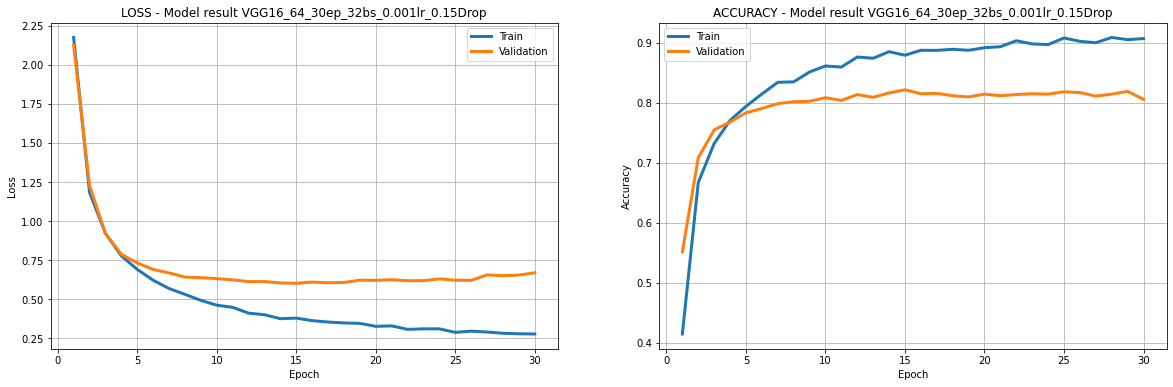

[INFO] MODEL LOADING FUNCTION ...

Error : 6


TypeError: cannot unpack non-iterable NoneType object

In [13]:
#load all the 256 not augmented models
_, par_VGG16_256 = LOAD_MODEL_and_PARAMS(if_input = False, mod_number=4, mod_size_number=9, load_model=False)
_, par_VGG19_256 = LOAD_MODEL_and_PARAMS(if_input = False, mod_number=6, mod_size_number=0, load_model=False)
_, par_Inc_256   = LOAD_MODEL_and_PARAMS(if_input = False, mod_number=5, mod_size_number=7, load_model=False)
_, par_Res_256   = LOAD_MODEL_and_PARAMS(if_input = False, mod_number=1, mod_size_number=5, load_model=False)

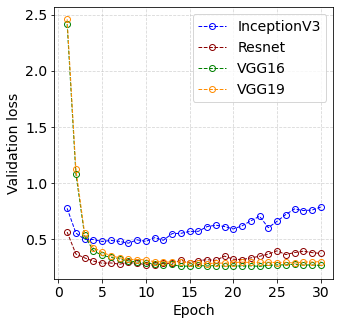

In [421]:
fig = plt.figure(figsize = (5,5))
plt.plot(x, par_Inc_256['val_loss'], label = "InceptionV3", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "blue", linewidth = 1)
plt.plot(x,par_Res_256['val_loss'], label = "Resnet", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "darkred", linewidth = 1)
plt.plot(x, par_VGG16_256['val_loss'], label = "VGG16", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "green", linewidth = 1)
plt.plot(x,par_VGG19_256['val_loss'], label = "VGG19",  marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "darkorange", linewidth = 1)
plt.xlabel("Epoch", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Validation loss", fontsize = 14)
plt.grid(linestyle = "--", alpha = 0.5)
plt.legend(fontsize = 14)
plt.show()
fig.savefig("defalut_comparison_loss.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

## PLOTS OF TRAINING VS. VALIDATION FOR INCEPTION AND RESNET

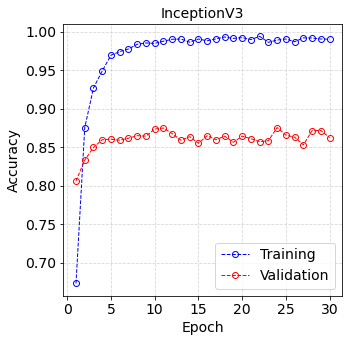

In [93]:
fig = plt.figure(figsize = (5,5))
plt.plot(x, par_Inc_256["accuracy"], label = "Training", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "blue", linewidth = 1)
plt.plot(x, par_Inc_256['val_accuracy'], label = "Validation", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "red", linewidth = 1)
plt.xlabel("Epoch", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("InceptionV3", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.grid(linestyle = "--", alpha = 0.5)
plt.legend(fontsize = 14)
plt.show()
fig.savefig("inception_val_tr.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

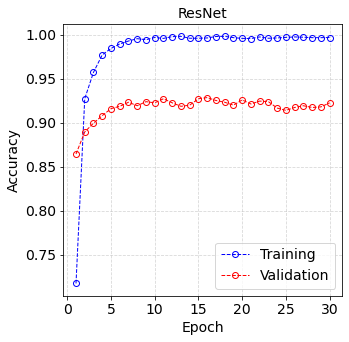

In [92]:
fig = plt.figure(figsize = (5,5))
plt.plot(x, par_Res_256["accuracy"], label = "Training", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "blue", linewidth = 1)
plt.plot(x, par_Res_256['val_accuracy'], label = "Validation", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "red", linewidth = 1)
plt.xlabel("Epoch", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("ResNet", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.grid(linestyle = "--", alpha = 0.5)
plt.legend(fontsize = 14)
plt.show()
fig.savefig("Res_val_tr.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

## COMPARE VGG16 DIFFERENT SIZES

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG16
Selected file: VGG16_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG16_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



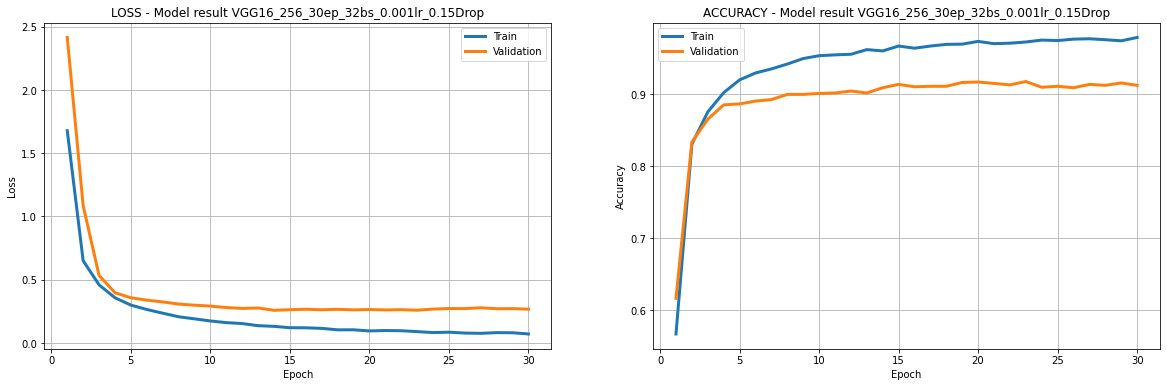

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG16
Selected file: VGG16_128_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG16_128_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



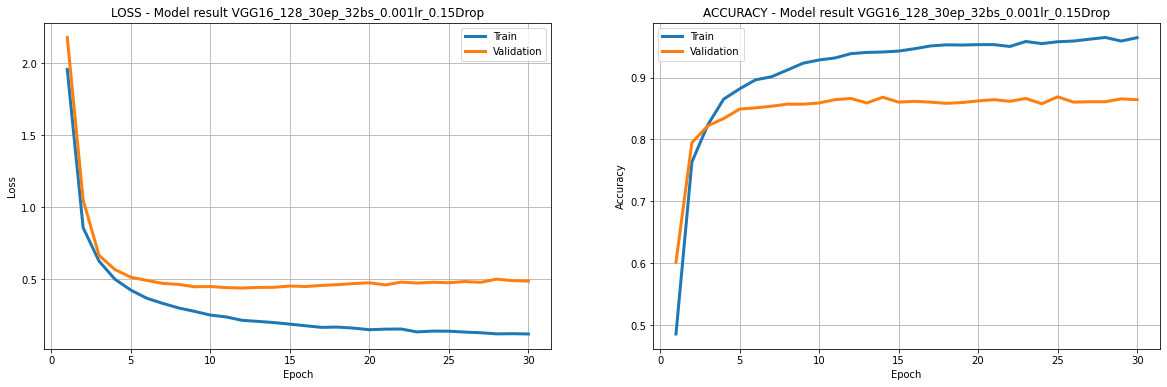

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG16
Selected file: VGG16_64_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG16_64_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



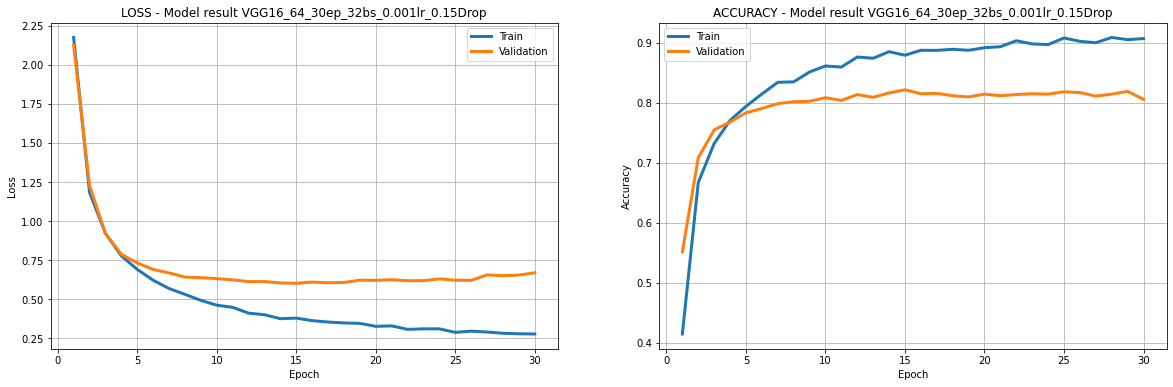

In [59]:
VGG16_256, par_vgg_256 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=4, mod_size_number=9, load_model = False)
VGG16_128, par_vgg_128 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=4, mod_size_number=5, load_model = False)
VGG16_64,  par_vgg_64   = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=4, mod_size_number=1, load_model = False)


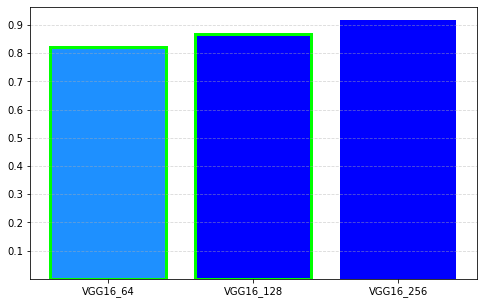

In [60]:
fig = plt.figure(figsize = (8,5))
plt.bar(x = "VGG16_64", height = np.max(par_vgg_64["val_accuracy"]), color = "dodgerblue", edgecolor = "lime", linewidth = 3)
plt.bar(x = "VGG16_128", height = np.max(par_vgg_128["val_accuracy"]), color = "blue", edgecolor = "lime", linewidth = 3)
plt.bar(x = "VGG16_256", height = np.max(par_vgg_256["val_accuracy"]), color = "blue")

plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.grid(axis = "y",linestyle = "--", alpha = 0.5)

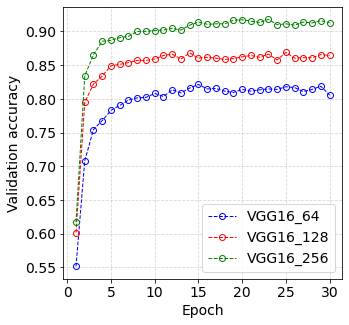

In [70]:
fig = plt.figure(figsize = (5,5))
x = np.arange(1, 31, 1)
plt.plot(x,par_vgg_64["val_accuracy"], marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "blue", label = "VGG16_64", linewidth = 1)
plt.plot(x,par_vgg_128["val_accuracy"], marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "red", label = "VGG16_128", linewidth = 1)
plt.plot(x,par_vgg_256["val_accuracy"], marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "green", label = "VGG16_256", linewidth = 1)
plt.xlabel("Epoch", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Validation accuracy", fontsize = 14)
plt.grid(linestyle = "--", alpha = 0.5)
plt.legend(fontsize = 14)
plt.show()
fig.savefig("size_acc.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

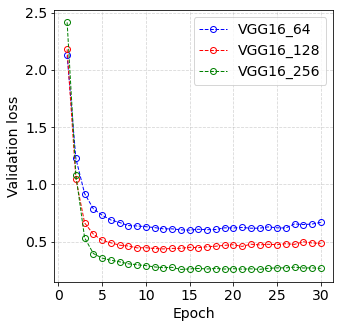

In [71]:
fig = plt.figure(figsize = (5,5))
x = np.arange(1, 31, 1)
plt.plot(x,par_vgg_64["val_loss"], marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "blue", label = "VGG16_64", linewidth = 1)
plt.plot(x,par_vgg_128["val_loss"], marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "red", label = "VGG16_128", linewidth = 1)
plt.plot(x,par_vgg_256["val_loss"], marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "green", label = "VGG16_256", linewidth = 1)
plt.xlabel("Epoch", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Validation loss", fontsize = 14)
plt.grid(linestyle = "--", alpha = 0.5)
plt.legend(fontsize = 14)
plt.show
fig.savefig("size_loss.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

<function matplotlib.pyplot.show(*args, **kw)>

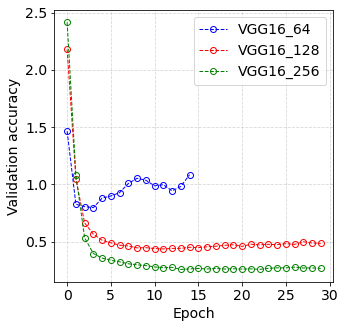

In [47]:
fig = plt.figure(figsize = (5,5))
plt.plot(par_vgg_64["val_loss"], marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "blue", label = "VGG16_64", linewidth = 1)
plt.plot(par_vgg_128["val_loss"], marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "red", label = "VGG16_128", linewidth = 1)
plt.plot(par_vgg_256["val_loss"], marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "green", label = "VGG16_256", linewidth = 1)
plt.xlabel("Epoch", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Validation accuracy", fontsize = 14)
plt.grid(linestyle = "--", alpha = 0.5)
plt.legend(fontsize = 14)
plt.show

#Loading the training and test set for a given size [64,128,256]
size = input("Insert the size of the dataset from the following [ 64, 128, 256 ]: ")
with open(f'/Users/PC-Home/Desktop/VCS/Dataset/train_and_test_set_{size}x{size}.pkl', 'rb') as f:
    dataset = pickle.load(f)

x_train, x_test, y_train, y_test = dataset["x_train"], dataset["x_test"], dataset["y_train"], dataset["y_test"]

In [47]:
EPOCHS = 25 # @param {type: "slider", min:8, max:80}
INIT_LR = 1e-3
BS = 32

image_size = 0
directory_root = 'PlantVillage-Dataset/raw/color/' #drive/MyDrive/Colab_Notebooks/PlantVillage-Dataset/color'

width= 256
height=width
depth=3

default_image_size = tuple((width, height))
from tensorflow.keras.applications.vgg16 import preprocess_input
def convert_image_to_array(image_dir, pretrained= False):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            image = img_to_array(image)
            if pretrained:
              image = preprocess_input(image)
            return image
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# Retrieving the images and resizing them
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    #reduce the dataset if RAM exceed the limit
    root_dir = root_dir
    
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
            
            # remove .DS_Store from list
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Strawberry___healthy ...
[INFO] Processing Strawberry___Leaf_scorch ...
[INFO] Processing Soybean___healthy ...
[INFO] Processing Squash___Powdery_mildew ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Raspberry___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Leaf_blight

In [48]:
aug = ImageDataGenerator(
                rotation_range=25,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2, 
                zoom_range=0.3,
                horizontal_flip=True, 
                fill_mode="nearest", )
    

In [49]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
np_image_list = np.array(image_list, dtype=np.float16) / 255.0
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

In [40]:
pred_VGG19_128  = VGG19_128.predict(x_test, batch_size=32, verbose=1,)

48/48 [==============================] - 735s 15s/step


In [69]:
true_cat = label_binarizer.inverse_transform(y_test[0:1])
#pred_cat = label_binarizer.inverse_transform(pred_VGG19_128)
#true_ca
true_cat

array(['Strawberry___healthy'], dtype='<U50')

In [71]:
data_tensor = tf.convert_to_tensor(np.float32(x_test[0]))
data_tensor

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.7607422 , 0.7451172 , 0.7685547 ],
        [0.78808594, 0.77246094, 0.79589844],
        [0.78027344, 0.76464844, 0.78808594],
        ...,
        [0.7138672 , 0.68603516, 0.7138672 ],
        [0.6821289 , 0.65478516, 0.6821289 ],
        [0.70996094, 0.6821289 , 0.70996094]],

       [[0.79589844, 0.78027344, 0.80371094],
        [0.80371094, 0.78808594, 0.81152344],
        [0.7841797 , 0.7685547 , 0.7919922 ],
        ...,
        [0.7216797 , 0.69433594, 0.7216797 ],
        [0.7060547 , 0.67822266, 0.7060547 ],
        [0.7529297 , 0.72558594, 0.7529297 ]],

       [[0.7607422 , 0.7451172 , 0.7685547 ],
        [0.7685547 , 0.7529297 , 0.7763672 ],
        [0.7451172 , 0.7294922 , 0.7529297 ],
        ...,
        [0.7060547 , 0.67822266, 0.7060547 ],
        [0.7138672 , 0.68603516, 0.7138672 ],
        [0.77246094, 0.7451172 , 0.77246094]],

       ...,

       [[0.5727539 , 0.5371094 , 0.5883789 ],
        [0.61

In [69]:

#for i in range(300, 400):
#print(i, "\n")
t = np.float32(aug.random_transform(data_tensor).numpy())
fig = plt.figure(figsize = (6,6))
plt.imshow(t)
plt.xticks([])
plt.yticks([])
plt.show()
#fig.savefig("foglia64.png", bbox_inches = 'tight', pad_inches = 0)
#plt.title("True category:\nPredicted Category:")

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'transpose'

(1471, 38)

In [54]:
width = width #################### modify here to change the input resolution
height= height
depth=3

default_image_size = tuple((width, height))

def convert_image_to_array(image_dir, pretrained= False):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            image = img_to_array(image)
            if pretrained:
              image = preprocess_input(image)
            return image
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

NameError: name 'x_test' is not defined

In [94]:
Print_all_models()

[INFO] ALL AVAILABLE MODEL

[1] <-- ResNet101V2
			[0] <-- ResNet101V2_128_30ep_32bs_0.001lr_0.15Drop  	[(1, 0)]
			[1] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.5Drop  	[(1, 1)]
			[2] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.5Drop  	[(1, 2)]
			[3] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 3)]
			[4] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 4)]
			[5] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.15Drop  	[(1, 5)]
			[6] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.5Drop  	[(1, 6)]
			[7] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.15Drop  	[(1, 7)]
			[8] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.5Drop  	[(1, 8)]
			[9] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.15Drop  	[(1, 9)]
[2] <-- InceptionResNetV2
			[0] <-- InceptionResNetV2_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(2, 0)]
			[1] <-- InceptionResNetV2_aug_256_50ep_32bs_0.0001lr_0.15Drop  	[(2, 1)]
[3] <-- EfficientNetB0
			[0] <-- EfficientNetB0_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(3, 0)

In [77]:
Print_all_models()

[INFO] ALL AVAILABLE MODEL

[1] <-- ResNet101V2
			[0] <-- ResNet101V2_128_30ep_32bs_0.001lr_0.15Drop  	[(1, 0)]
			[1] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.5Drop  	[(1, 1)]
			[2] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.5Drop  	[(1, 2)]
			[3] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 3)]
			[4] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 4)]
			[5] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.15Drop  	[(1, 5)]
			[6] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.5Drop  	[(1, 6)]
			[7] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.15Drop  	[(1, 7)]
			[8] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.5Drop  	[(1, 8)]
			[9] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.15Drop  	[(1, 9)]
[2] <-- InceptionResNetV2
			[0] <-- InceptionResNetV2_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(2, 0)]
			[1] <-- InceptionResNetV2_aug_256_50ep_32bs_0.0001lr_0.15Drop  	[(2, 1)]
[3] <-- EfficientNetB0
			[0] <-- EfficientNetB0_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(3, 0)

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



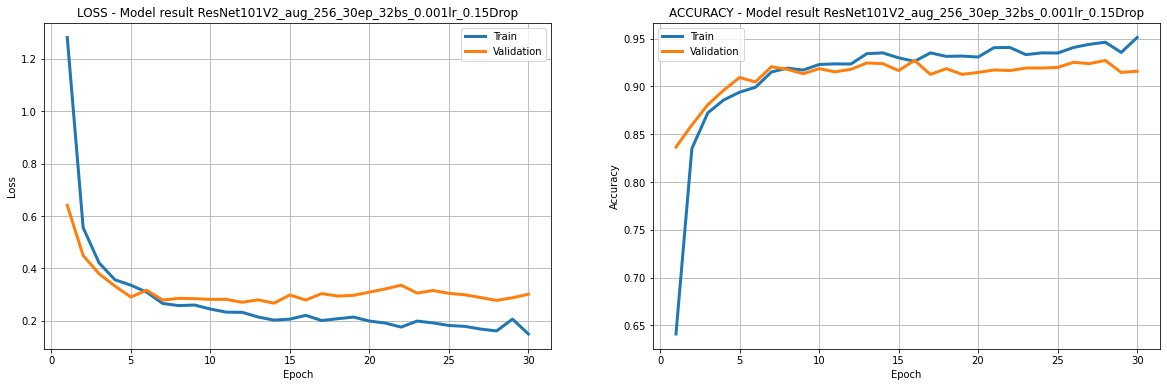

[INFO] MODEL LOADING FUNCTION ...

Selected model: InceptionV3
Selected file: InceptionV3_aug_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_InceptionV3_aug_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



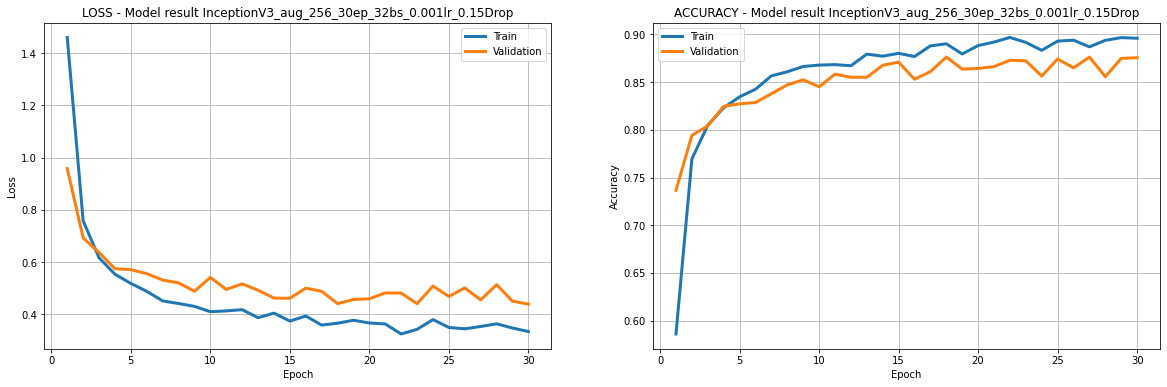

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG16
Selected file: VGG16_aug_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG16_aug_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



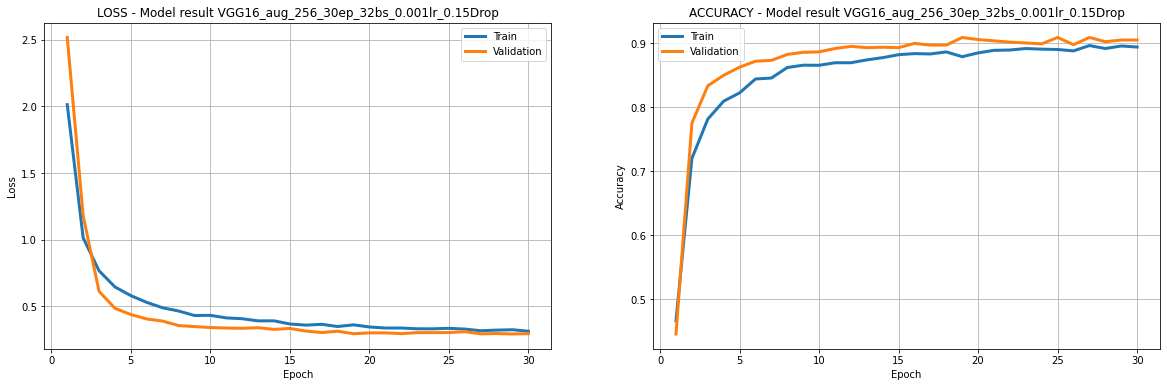

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG19
Selected file: VGG19_aug_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG19_aug_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



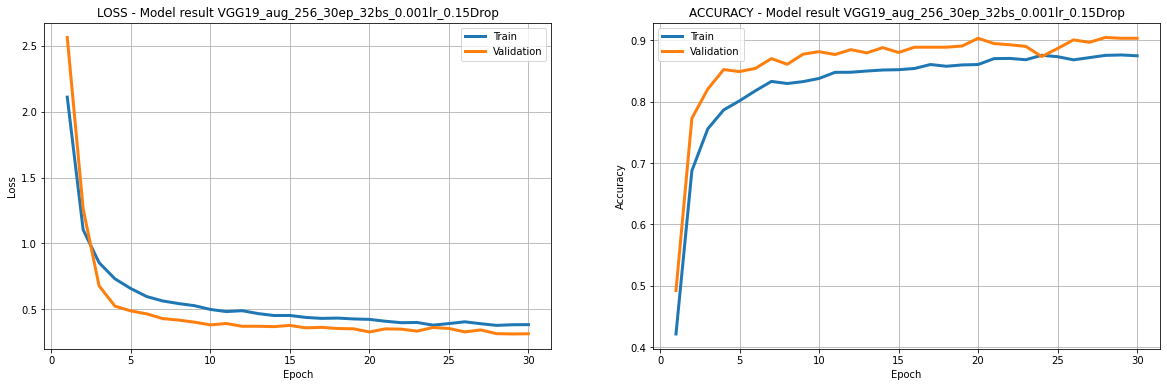

In [143]:
_, res_256_aug = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=4, load_model=False)
_, inc_256_aug = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=5, mod_size_number=7, load_model=False)
_, VGG16_256_aug = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=4, mod_size_number=6, load_model=False)
_, VGG19_256_aug = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=6, mod_size_number=1, load_model=False)

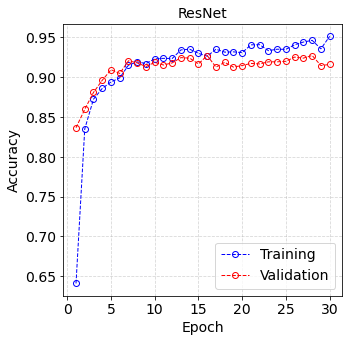

In [84]:
fig = plt.figure(figsize = (5,5))
x = np.arange(1, 31, 1)
plt.plot(x, res_256_aug["accuracy"], label = "Training", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "blue", linewidth = 1)
plt.plot(x, res_256_aug['val_accuracy'], label = "Validation", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "red", linewidth = 1)
plt.xlabel("Epoch", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("ResNet", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.grid(linestyle = "--", alpha = 0.5)
plt.legend(fontsize = 14)
plt.show()
fig.savefig("Res_val_tr_aug.pdf", bbox_inches = 'tight', pad_inches = 0)

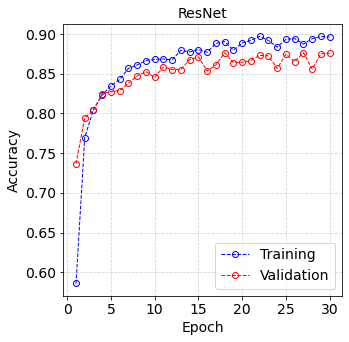

In [85]:
fig = plt.figure(figsize = (5,5))
x = np.arange(1, 31, 1)
plt.plot(x, inc_256_aug["accuracy"], label = "Training", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "blue", linewidth = 1)
plt.plot(x, inc_256_aug['val_accuracy'], label = "Validation", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "red", linewidth = 1)
plt.xlabel("Epoch", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("ResNet", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.grid(linestyle = "--", alpha = 0.5)
plt.legend(fontsize = 14)
plt.show()
fig.savefig("Inc_val_tr_aug.pdf", bbox_inches = 'tight', pad_inches = 0)

In [156]:
diff_res_aug = np.abs(np.mean(res_256_aug["accuracy"][-10:] - res_256_aug["val_accuracy"][-10:]))
diff_inc_aug = np.abs(np.mean(inc_256_aug["accuracy"][-10:] - inc_256_aug["val_accuracy"][-10:]))
diff_VGG16_aug = np.abs(np.mean(VGG16_256_aug["accuracy"][-10:] - VGG16_256_aug["val_accuracy"][-10:]))
diff_VGG19_aug = np.abs(np.mean(VGG19_256_aug["accuracy"][-10:] - VGG19_256_aug["val_accuracy"][-10:]))

In [144]:
diff_res_aug = np.abs(res_256_aug["accuracy"][-1] - res_256_aug["val_accuracy"][-1])
diff_inc_aug = np.abs(inc_256_aug["accuracy"][-1] - inc_256_aug["val_accuracy"][-1])
diff_VGG16_aug = np.abs(VGG16_256_aug["accuracy"][-1] - VGG16_256_aug["val_accuracy"][-1])
diff_VGG19_aug = np.abs(VGG19_256_aug["accuracy"][-1] - VGG19_256_aug["val_accuracy"][-1])

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG16
Selected file: VGG16_64_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG16_64_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



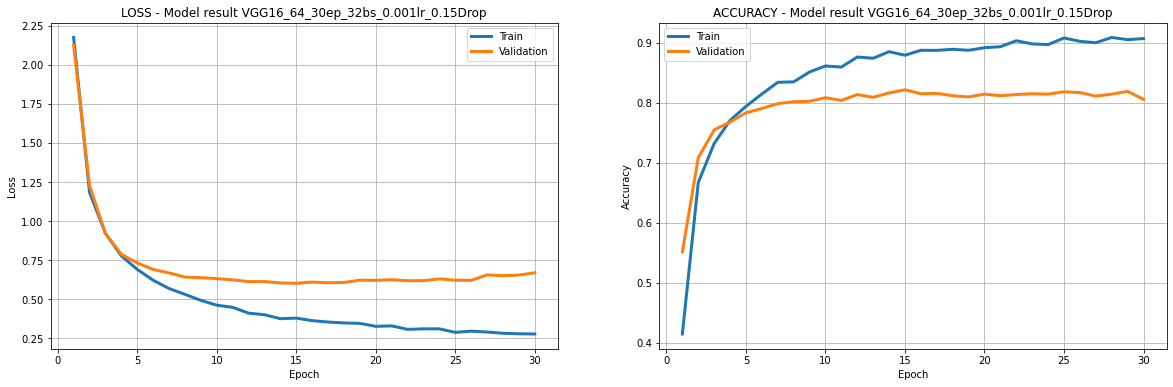

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG19
Selected file: VGG19_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG19_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



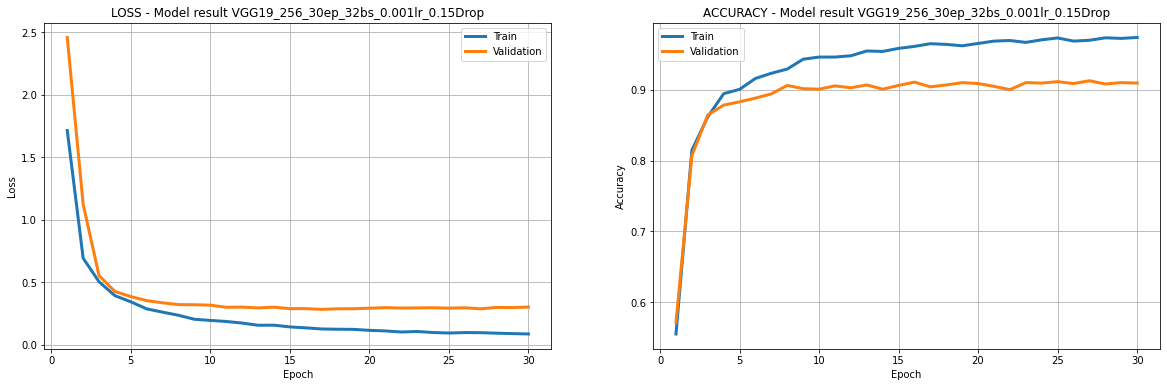

[INFO] MODEL LOADING FUNCTION ...

Selected model: InceptionV3
Selected file: InceptionV3_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_InceptionV3_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



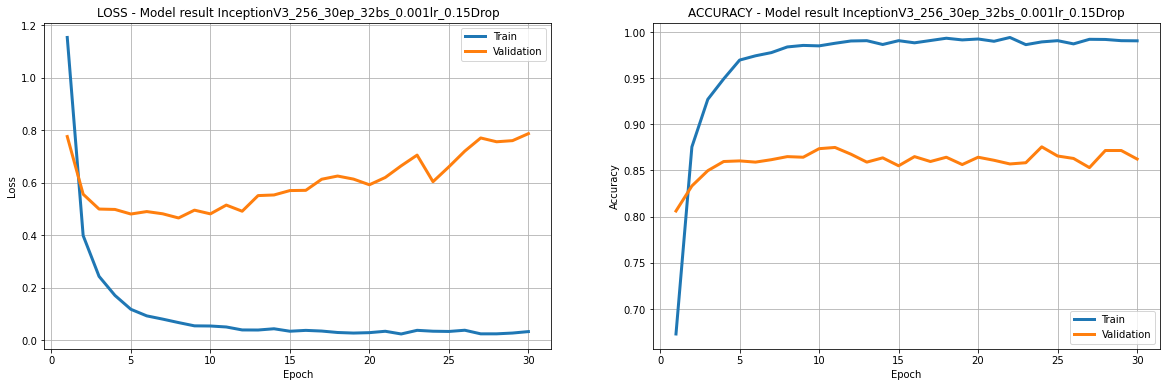

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



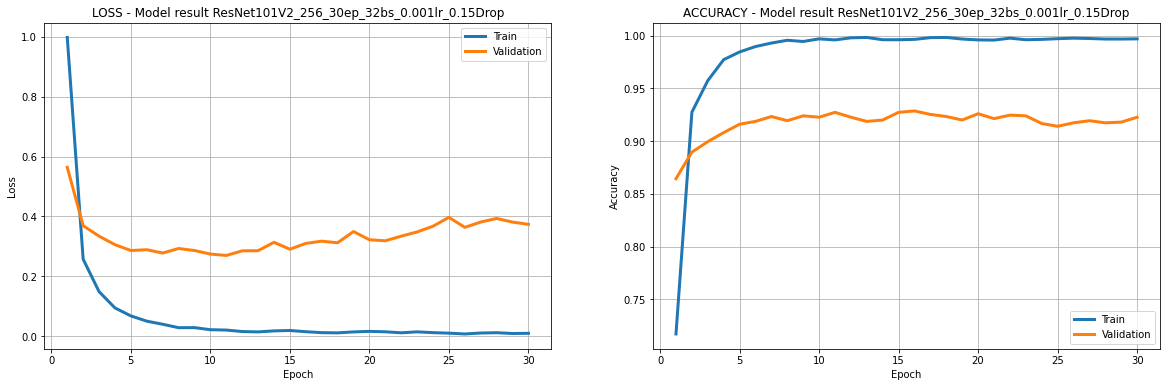

In [145]:
#load all the 256 not augmented models
_, VGG16_256 = LOAD_MODEL_and_PARAMS(if_input = False, mod_number=4, mod_size_number=1, load_model=False)
_, VGG19_256 = LOAD_MODEL_and_PARAMS(if_input = False, mod_number=6, mod_size_number=0, load_model=False)
_, inc_256   = LOAD_MODEL_and_PARAMS(if_input = False, mod_number=5, mod_size_number=5, load_model=False)
_, res_256   = LOAD_MODEL_and_PARAMS(if_input = False, mod_number=1, mod_size_number=3, load_model=False)

In [157]:
diff_res = np.abs(np.mean(res_256["accuracy"][-10:] - res_256["val_accuracy"][-10:]))
diff_inc = np.abs(np.mean(inc_256["accuracy"][-10:] - inc_256["val_accuracy"][-10:]))
diff_VGG16 = np.abs(np.mean(VGG16_256["accuracy"][-10:] - VGG16_256["val_accuracy"][-10:]))
diff_VGG19 = np.abs(np.mean(VGG19_256["accuracy"][-10:] - VGG19_256["val_accuracy"][-10:]))

In [146]:
diff_res = np.abs(res_256["accuracy"][-1] - res_256["val_accuracy"][-1])
diff_inc = np.abs(inc_256["accuracy"][-1] - inc_256["val_accuracy"][-1])
diff_VGG16 = np.abs(VGG16_256["accuracy"][-1] - VGG16_256["val_accuracy"][-1])
diff_VGG19 = np.abs(VGG19_256["accuracy"][-1] - VGG19_256["val_accuracy"][-1])

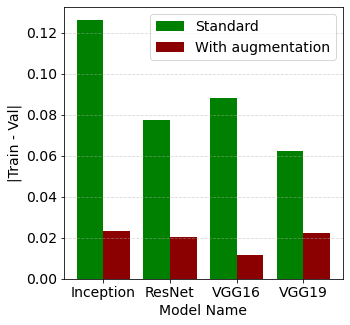

In [165]:
# Numbers of pairs of bars you want
N = 4
size = 14
# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = (diff_inc, diff_res, diff_VGG16, diff_VGG19)
# Specify the values of orange bars (height)
orange_bar = (diff_inc_aug, diff_res_aug, diff_VGG16_aug, diff_VGG19_aug)

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
fig = plt.figure(figsize=(5,5))

# Width of a bar 
width = 0.4  

# Plotting
plt.bar(ind, blue_bar , width, label='Standard', color = "green")
plt.bar(ind + width, orange_bar, width, label='With augmentation', color = "darkred")

plt.xlabel('Model Name', fontsize = size)
plt.ylabel('|Train - Val|', fontsize = size)
#plt.title('Here goes title of the plot')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('Inception', 'ResNet', 'VGG16', "VGG19"), fontsize = size)
plt.yticks(fontsize = size)
# Finding the best position for legends and putting it
plt.legend(loc='best', fontsize = size)
plt.grid(axis = "y", linestyle = "--", alpha = 0.5)
plt.show()
fig.savefig("aug_nonaug.pdf", bbox_inches = 'tight', pad_inches = 0)

## BATCH SIZE

In [159]:
diff_res_aug

0.020335698127746583

In [160]:
np.abs(res_256_aug["accuracy"][-1] - res_256_aug["val_accuracy"][-1])

0.03529012203216553

In [223]:
Print_all_models()

[INFO] ALL AVAILABLE MODEL

[1] <-- ResNet101V2
			[0] <-- ResNet101V2_128_30ep_32bs_0.001lr_0.15Drop  	[(1, 0)]
			[1] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.5Drop  	[(1, 1)]
			[2] <-- .DS_Store  	[(1, 2)]
			[3] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.5Drop  	[(1, 3)]
			[4] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.3Drop  	[(1, 4)]
			[5] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 5)]
			[6] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.3Drop  	[(1, 6)]
			[7] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop_0.4test  	[(1, 7)]
			[8] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 8)]
			[9] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.15Drop  	[(1, 9)]
			[10] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.5Drop  	[(1, 10)]
			[11] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.15Drop  	[(1, 11)]
			[12] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.5Drop  	[(1, 12)]
			[13] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.15Drop  	[(1, 13)]
[2] <-- InceptionResN

[INFO] MODEL LOADING FUNCTION ...

Selected model: InceptionV3
Selected file: InceptionV3_aug_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_InceptionV3_aug_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



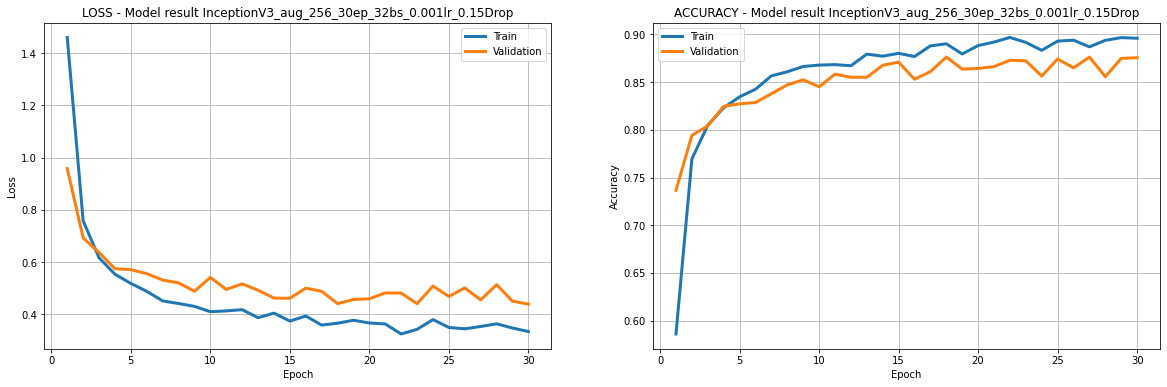

[INFO] MODEL LOADING FUNCTION ...

Selected model: InceptionV3
Selected file: InceptionV3_aug_256_30ep_120bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_InceptionV3_aug_256_30ep_120bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



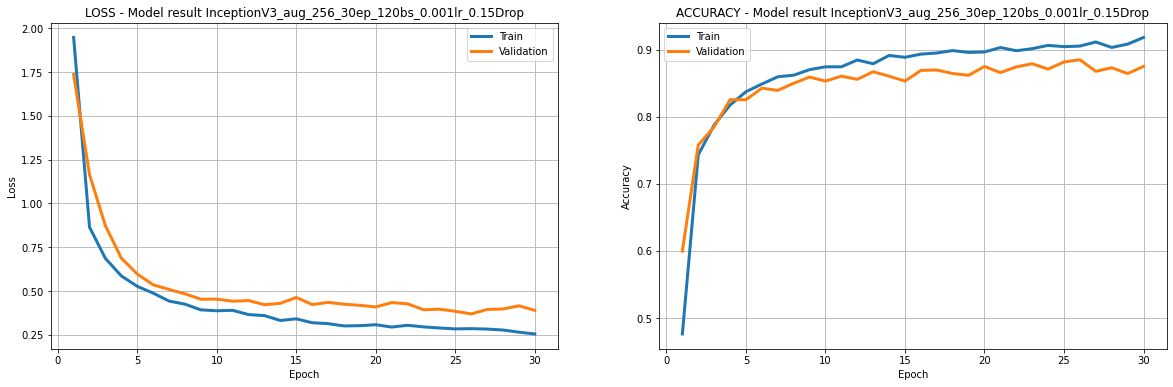

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



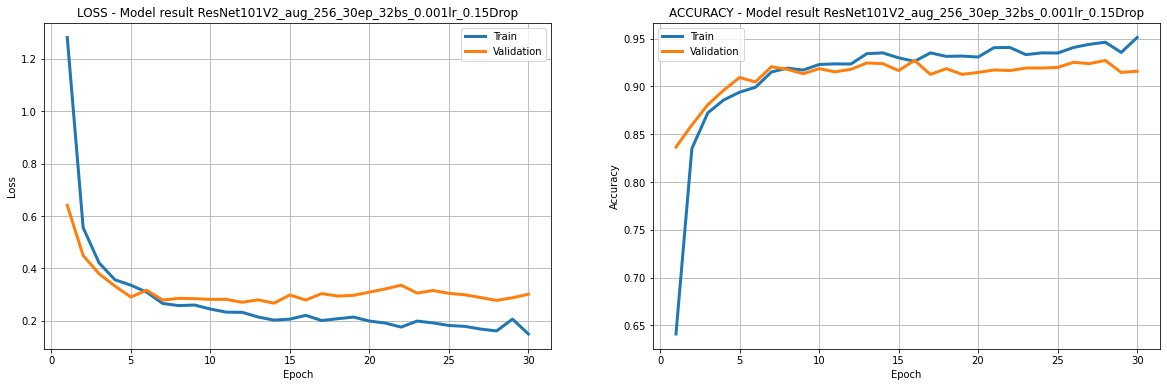

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_aug_256_30ep_64bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_aug_256_30ep_64bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



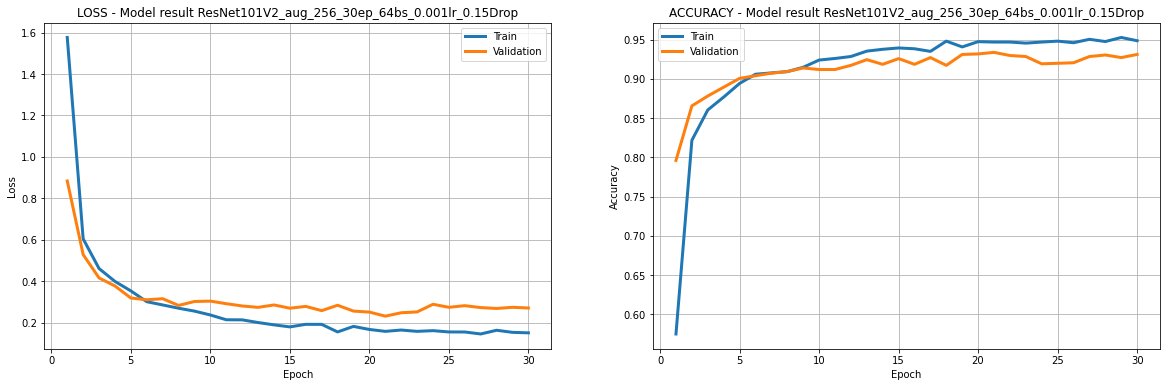

In [224]:
_, inception_batch_32 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=5, mod_size_number=10, load_model=False)
_, inception_batch_120 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=5, mod_size_number=12, load_model=False)
_, resnet_batch_32 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=8, load_model=False)
_, resnet_batch_64 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=13, load_model=False)

In [227]:
print(np.max(inception_batch_32["val_accuracy"][-1]))
print(np.max(inception_batch_120["val_accuracy"][-1]))
print(np.max(resnet_batch_32["val_accuracy"][-1]))
print(np.max(resnet_batch_64["val_accuracy"][-1]))

0.8755790591239929
0.8749172687530518
0.9159497022628784
0.9311714172363281


## LEARNING RATE

In [129]:
Print_all_models()

[INFO] ALL AVAILABLE MODEL

[1] <-- ResNet101V2
			[0] <-- ResNet101V2_128_30ep_32bs_0.001lr_0.15Drop  	[(1, 0)]
			[1] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.5Drop  	[(1, 1)]
			[2] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.5Drop  	[(1, 2)]
			[3] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 3)]
			[4] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 4)]
			[5] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.15Drop  	[(1, 5)]
			[6] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.5Drop  	[(1, 6)]
			[7] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.15Drop  	[(1, 7)]
			[8] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.5Drop  	[(1, 8)]
			[9] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.15Drop  	[(1, 9)]
[2] <-- InceptionResNetV2
			[0] <-- InceptionResNetV2_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(2, 0)]
			[1] <-- InceptionResNetV2_aug_256_50ep_32bs_0.0001lr_0.15Drop  	[(2, 1)]
[3] <-- EfficientNetB0
			[0] <-- EfficientNetB0_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(3, 0)

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



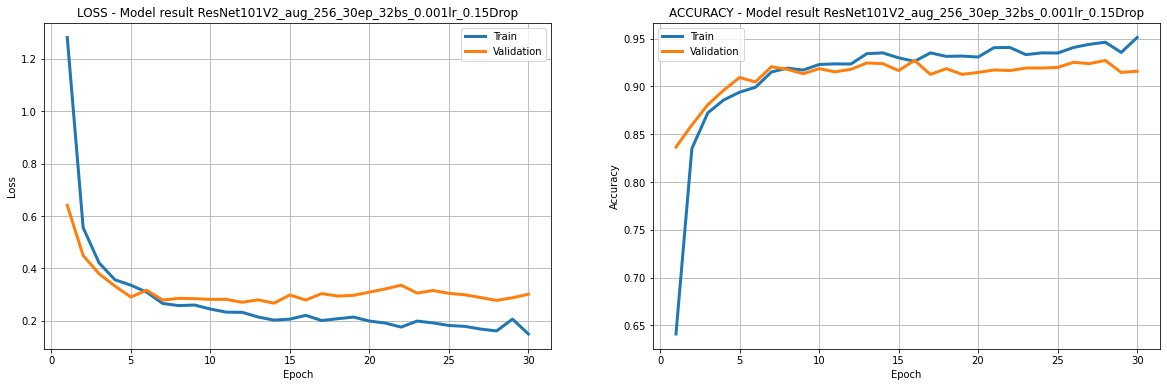

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



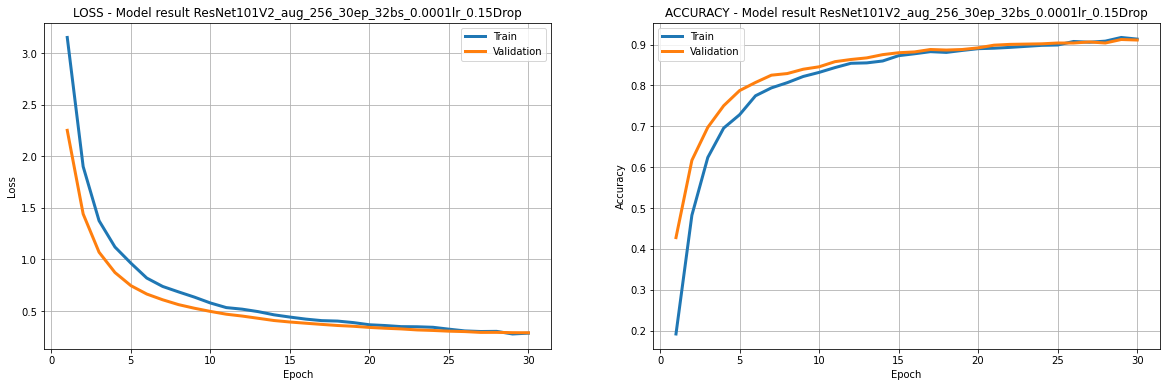

In [131]:
_, res_lr3 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=4, load_model=False)
_, res_lr4 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=7, load_model=False)

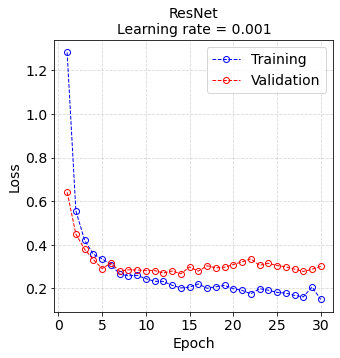

In [141]:
fig = plt.figure(figsize = (5,5))
x = np.arange(1, 31, 1)
plt.plot(x, res_lr3["loss"], label = "Training", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "blue", linewidth = 1)
plt.plot(x, res_lr3['val_loss'], label = "Validation", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "red", linewidth = 1)
plt.xlabel("Epoch", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("ResNet\nLearning rate = 0.001", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
plt.grid(linestyle = "--", alpha = 0.5)
plt.legend(fontsize = 14)
plt.show()
fig.savefig("res_aug_lr3.pdf", bbox_inches = 'tight', pad_inches = 0)

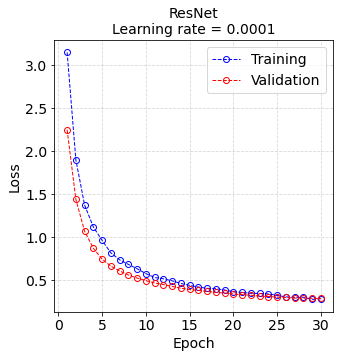

In [140]:
fig = plt.figure(figsize = (5,5))
x = np.arange(1, 31, 1)
plt.plot(x, res_lr4["loss"], label = "Training", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "blue", linewidth = 1)
plt.plot(x, res_lr4['val_loss'], label = "Validation", marker = "o", markersize = 6, markerfacecolor = "None",
         linestyle = "--", color = "red", linewidth = 1)
plt.xlabel("Epoch", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("ResNet\nLearning rate = 0.0001", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
plt.grid(linestyle = "--", alpha = 0.5)
plt.legend(fontsize = 14)
plt.show()
fig.savefig("res_aug_lr4.pdf", bbox_inches = 'tight', pad_inches = 0)

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG16
Selected file: VGG16_256_50ep_32bs_0.0001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG16_256_50ep_32bs_0.0001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



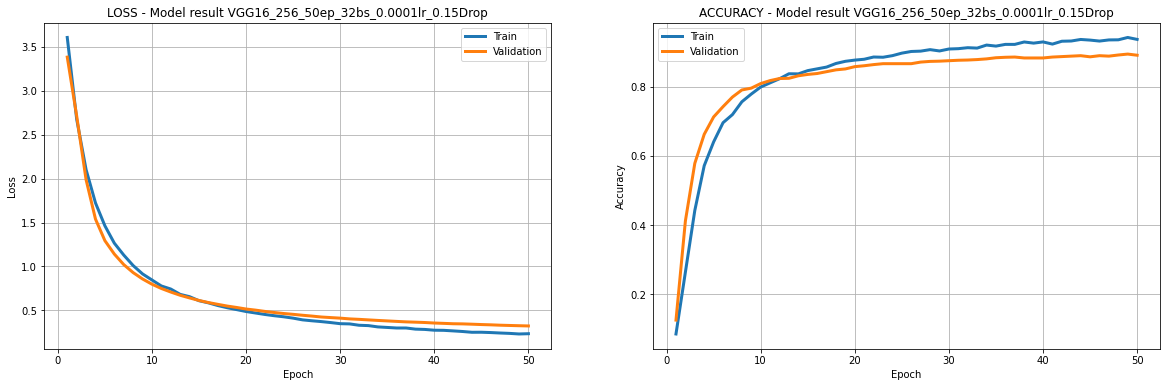

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG16
Selected file: VGG16_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG16_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



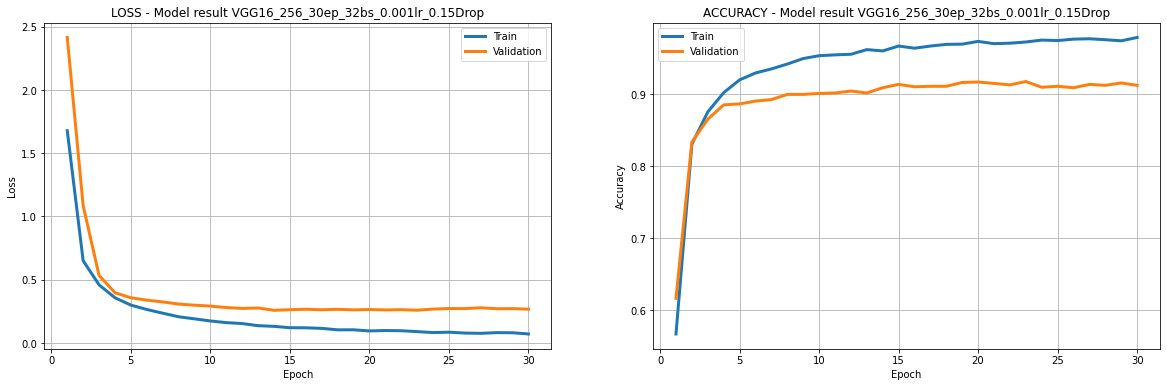

In [167]:
_, VGG16_aug_lr4_50ep = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=4, mod_size_number=7, load_model=False)
_, VGG16_aug_lr3_30ep = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=4, mod_size_number=9, load_model=False)

In [176]:
np.max(VGG19_aug_lr4_50ep["val_accuracy"])

0.8960952758789062

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG19
Selected file: VGG19_256_50ep_32bs_0.0001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG19_256_50ep_32bs_0.0001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



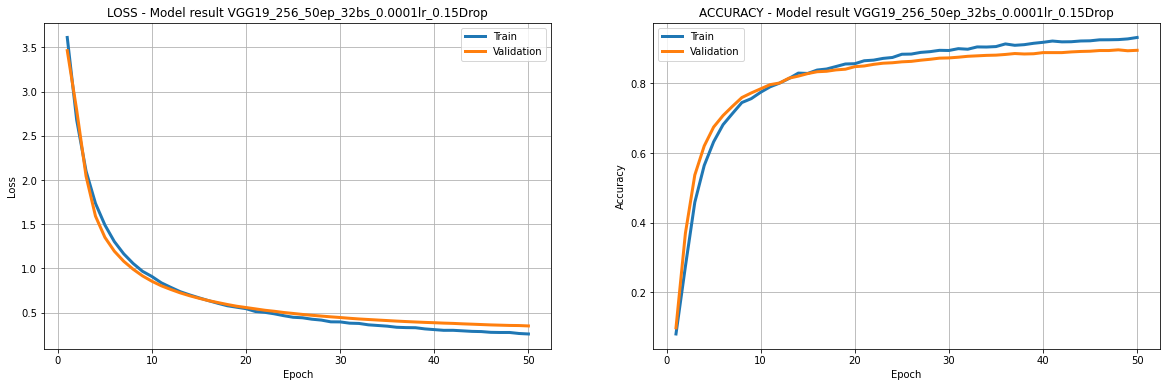

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG19
Selected file: VGG19_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG19_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



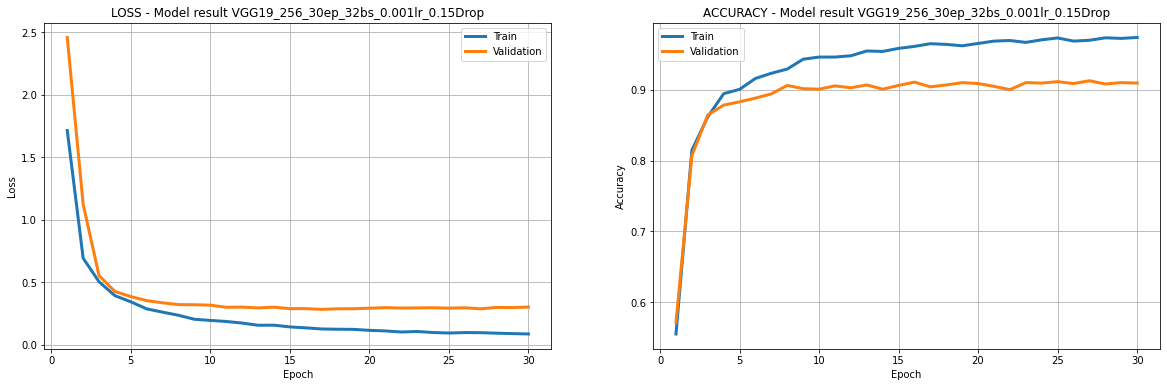

In [174]:
_, VGG19_aug_lr4_50ep = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=6, mod_size_number=3, load_model=False)
_, VGG19_aug_lr3_30ep = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=6, mod_size_number=0, load_model=False)

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



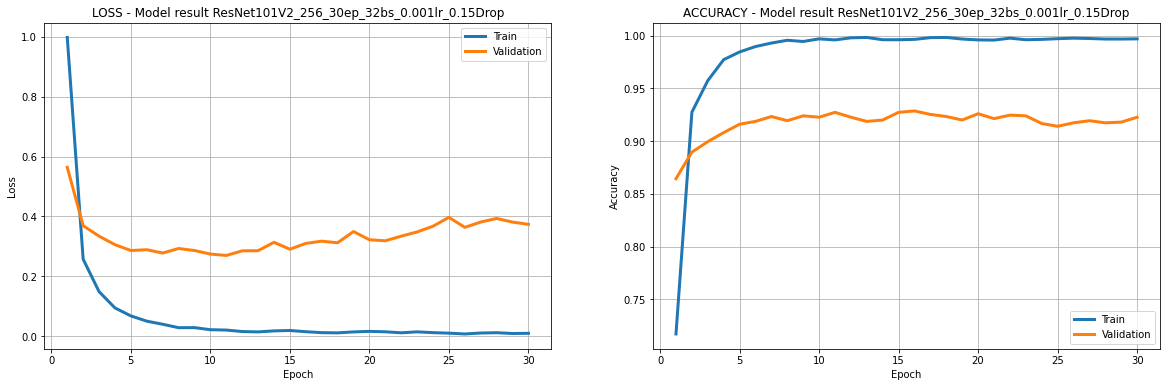

[INFO] MODEL LOADING FUNCTION ...

Selected model: InceptionV3
Selected file: InceptionV3_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_InceptionV3_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



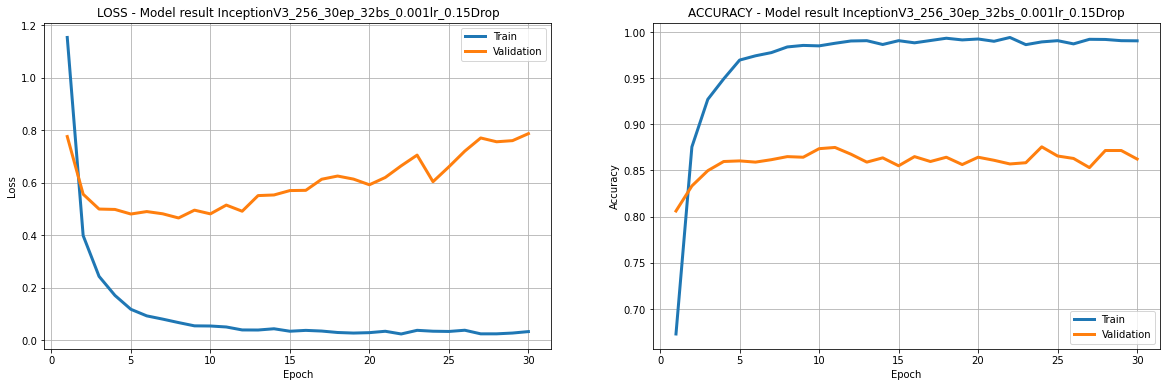

In [177]:
_, res = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=3, load_model=False)
_, inc = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=5, mod_size_number=5, load_model=False)

## DROPOUT

In [186]:
Print_all_models()

[INFO] ALL AVAILABLE MODEL

[1] <-- ResNet101V2
			[0] <-- ResNet101V2_128_30ep_32bs_0.001lr_0.15Drop  	[(1, 0)]
			[1] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.5Drop  	[(1, 1)]
			[2] <-- .DS_Store  	[(1, 2)]
			[3] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.5Drop  	[(1, 3)]
			[4] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.3Drop  	[(1, 4)]
			[5] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 5)]
			[6] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.3Drop  	[(1, 6)]
			[7] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop_0.4test  	[(1, 7)]
			[8] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 8)]
			[9] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.15Drop  	[(1, 9)]
			[10] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.5Drop  	[(1, 10)]
			[11] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.15Drop  	[(1, 11)]
			[12] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.5Drop  	[(1, 12)]
			[13] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.15Drop  	[(1, 13)]
[2] <-- InceptionResN

In [188]:
np.max(res_03["val_accuracy"])

0.9324950575828552

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



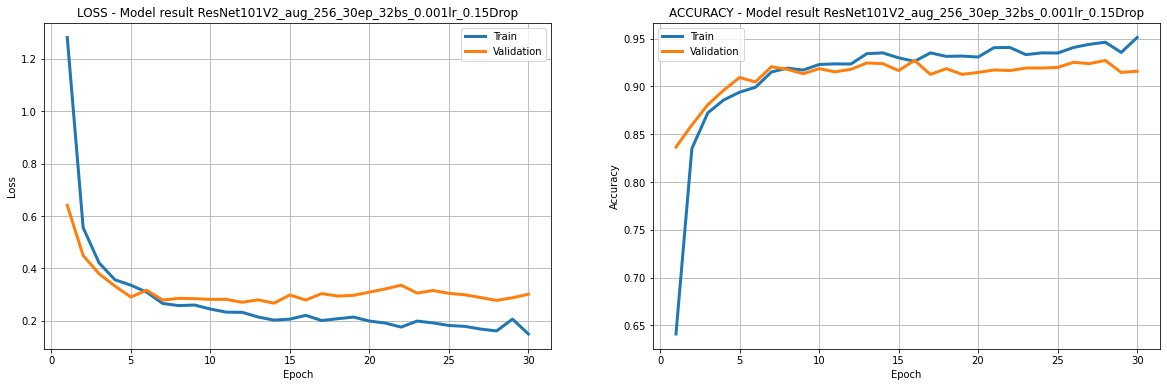

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_aug_256_30ep_32bs_0.001lr_0.3Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_aug_256_30ep_32bs_0.001lr_0.3Drop.txt <--

[INFO] Loading PARAMETERS completed



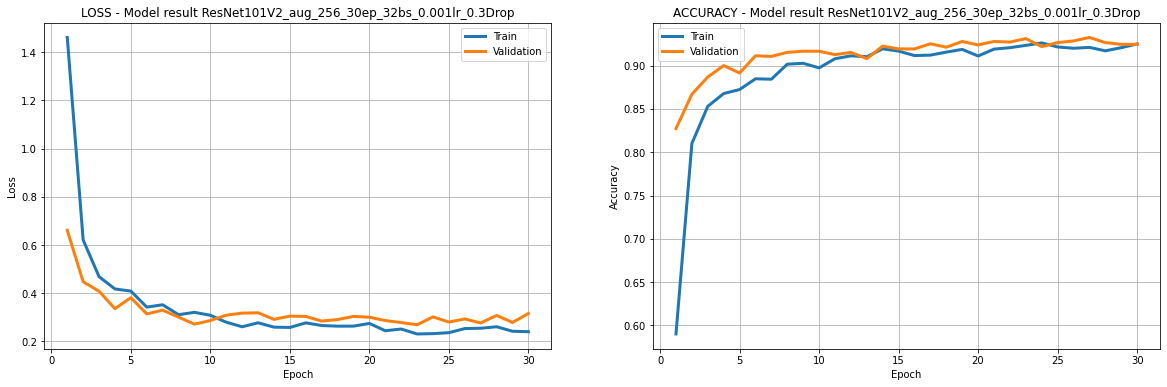

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_aug_256_30ep_32bs_0.001lr_0.5Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_aug_256_30ep_32bs_0.001lr_0.5Drop.txt <--

[INFO] Loading PARAMETERS completed



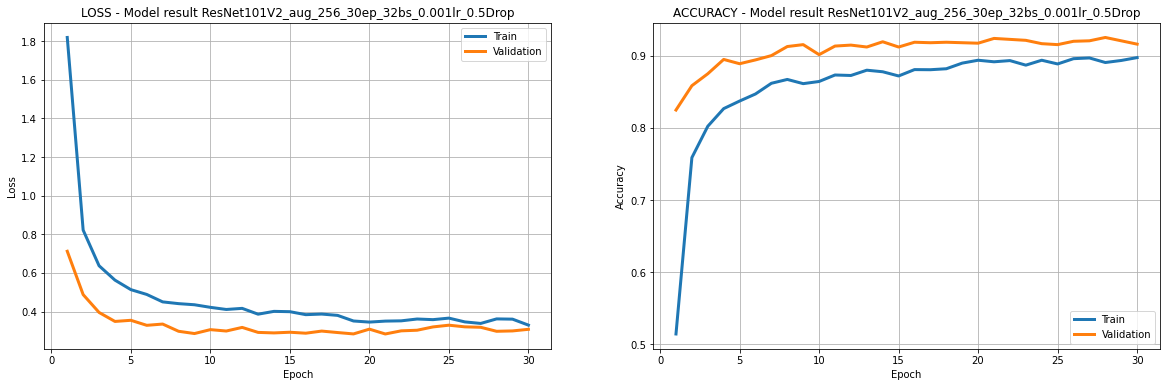

[INFO] MODEL LOADING FUNCTION ...

Selected model: InceptionV3
Selected file: InceptionV3_aug_256_30ep_120bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_InceptionV3_aug_256_30ep_120bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



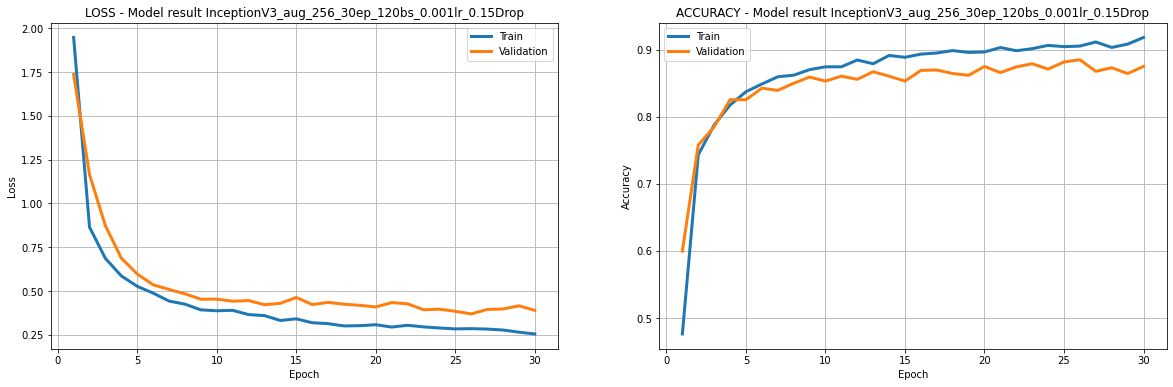

[INFO] MODEL LOADING FUNCTION ...

Selected model: InceptionV3
Selected file: InceptionV3_aug_256_50ep_32bs_0.0001lr_0.25Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_InceptionV3_aug_256_50ep_32bs_0.0001lr_0.25Drop.txt <--

[INFO] Loading PARAMETERS completed



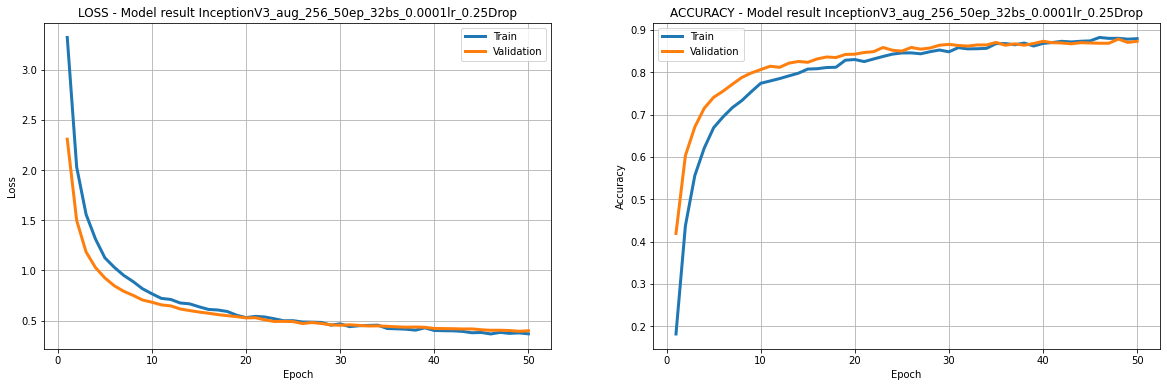

[INFO] MODEL LOADING FUNCTION ...

Selected model: InceptionV3
Selected file: InceptionV3_aug_256_30ep_32bs_0.001lr_0.5Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_InceptionV3_aug_256_30ep_32bs_0.001lr_0.5Drop.txt <--

[INFO] Loading PARAMETERS completed



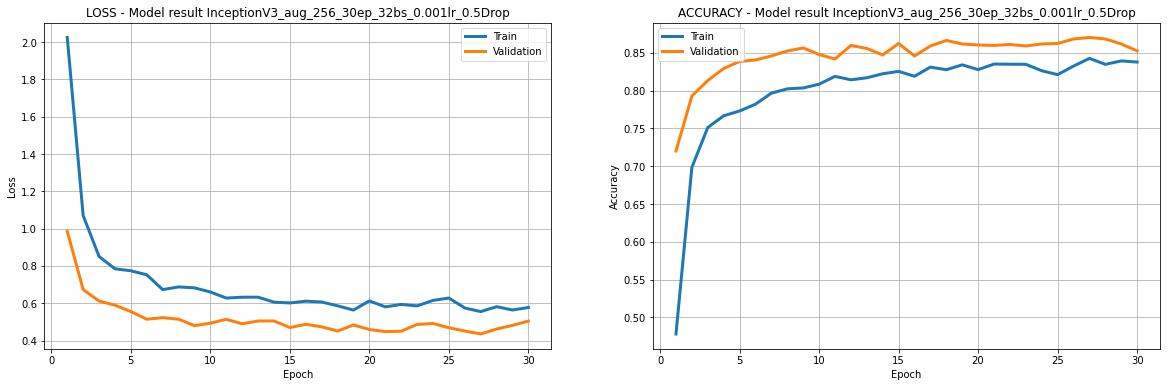

In [190]:
_, res_015 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=8, load_model=False)
_, res_03 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=4, load_model=False)
_, res_05  = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=1, load_model=False)

_, inc_015 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=5, mod_size_number=12, load_model=False)
_, inc_03 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=5, mod_size_number=13, load_model=False)
_, inc_05  = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=5, mod_size_number=0, load_model=False)

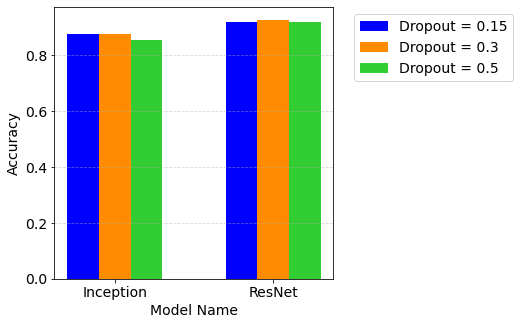

In [202]:
# Numbers of pairs of bars you want
N = 2
size = 14
# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = (np.mean(inc_015["val_accuracy"][-1:]), np.mean(res_015["val_accuracy"][-1:]))
# Specify the values of orange bars (height)
second_bar = (np.mean(inc_03["val_accuracy"][-1:]), np.mean(res_03["val_accuracy"][-1:]))
orange_bar = (np.mean(inc_05["val_accuracy"][-1:]), np.mean(res_05["val_accuracy"][-1:]))



# Position of bars on x-axis
ind = np.arange(N)

# Figure size
fig = plt.figure(figsize=(5,5))

# Width of a bar 
width = 0.2  

# Plotting
plt.bar(ind, blue_bar , width, label='Dropout = 0.15', color = "blue")
plt.bar(ind + width, second_bar, width, label='Dropout = 0.3', color = "darkorange")
plt.bar(ind + 2*width, orange_bar, width, label='Dropout = 0.5', color = "limegreen")

plt.xlabel('Model Name', fontsize = size)
plt.ylabel('Accuracy', fontsize = size)
#plt.title('Here goes title of the plot')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width, ('Inception', 'ResNet'), fontsize = size)
plt.yticks(fontsize = size)
# Finding the best position for legends and putting it
plt.legend(fontsize = size, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis = "y", linestyle = "--", alpha = 0.5)
plt.show()
fig.savefig("dropout.pdf", bbox_inches = 'tight', pad_inches = 0)

## DIFFERENT TRAIN AND TEST

In [203]:
Print_all_models()

[INFO] ALL AVAILABLE MODEL

[1] <-- ResNet101V2
			[0] <-- ResNet101V2_128_30ep_32bs_0.001lr_0.15Drop  	[(1, 0)]
			[1] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.5Drop  	[(1, 1)]
			[2] <-- .DS_Store  	[(1, 2)]
			[3] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.5Drop  	[(1, 3)]
			[4] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.3Drop  	[(1, 4)]
			[5] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 5)]
			[6] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.3Drop  	[(1, 6)]
			[7] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop_0.4test  	[(1, 7)]
			[8] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 8)]
			[9] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.15Drop  	[(1, 9)]
			[10] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.5Drop  	[(1, 10)]
			[11] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.15Drop  	[(1, 11)]
			[12] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.5Drop  	[(1, 12)]
			[13] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.15Drop  	[(1, 13)]
[2] <-- InceptionResN

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_aug_256_30ep_32bs_0.001lr_0.3Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_aug_256_30ep_32bs_0.001lr_0.3Drop.txt <--

[INFO] Loading PARAMETERS completed



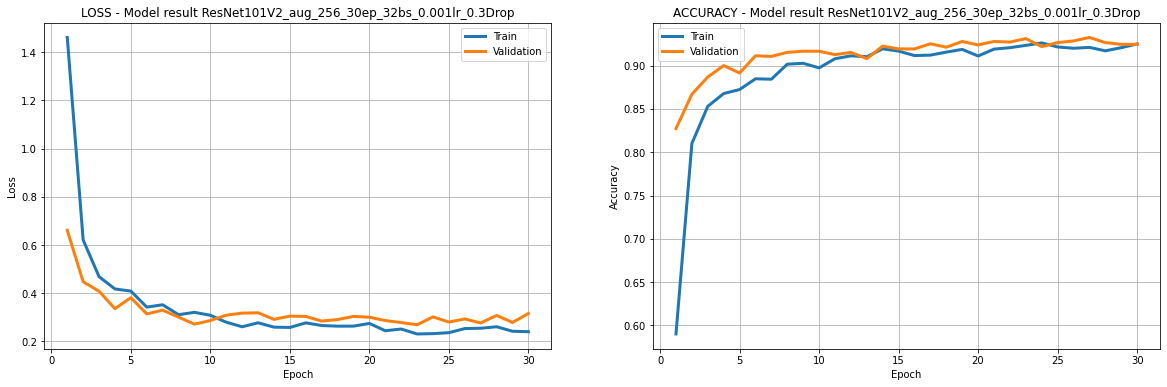

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop_0.4test
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop_0.4test.txt <--

[INFO] Loading PARAMETERS completed



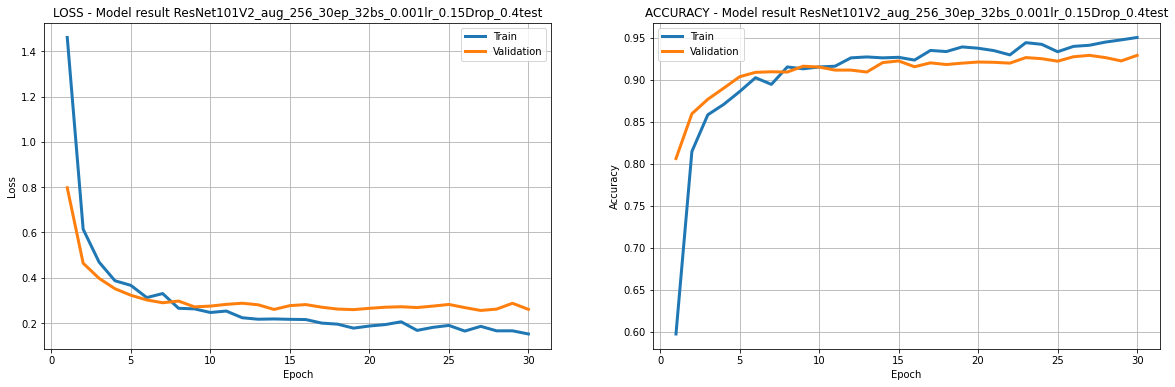

[INFO] MODEL LOADING FUNCTION ...

Selected model: InceptionV3
Selected file: InceptionV3_aug_256_30ep_32bs_0.01lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_InceptionV3_aug_256_30ep_32bs_0.01lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS completed



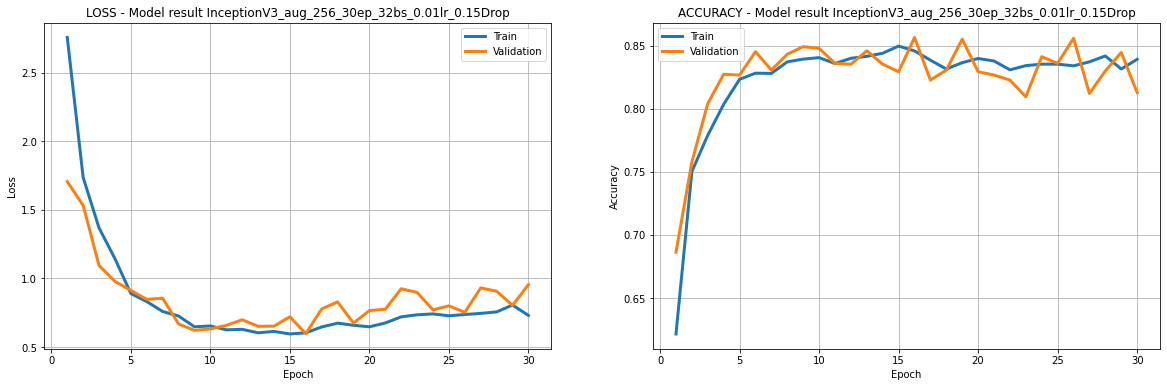

[INFO] MODEL LOADING FUNCTION ...

Selected model: InceptionV3
Selected file: InceptionV3_aug_256_30ep_32bs_0.001lr_0.15Drop_0.4test
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_InceptionV3_aug_256_30ep_32bs_0.001lr_0.15Drop_0.4test.txt <--

[INFO] Loading PARAMETERS completed



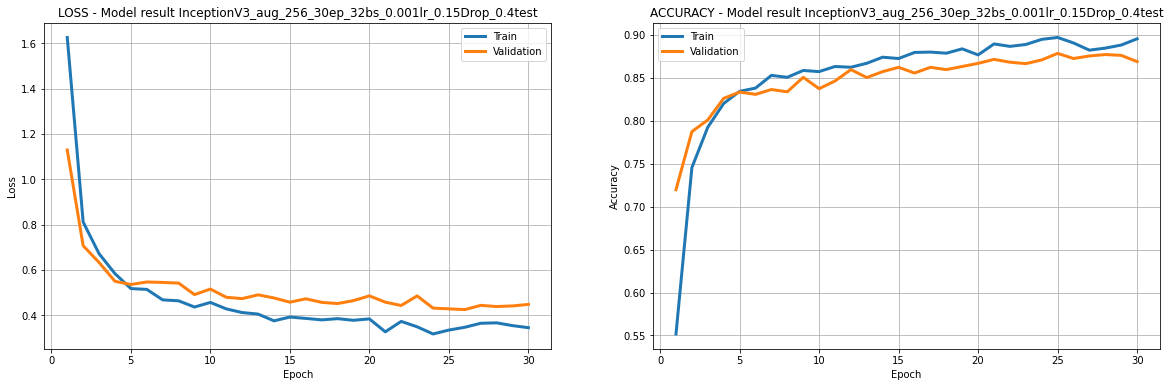

In [205]:
_, res_test_originale = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=4, load_model=False)
_, res_test_04 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=7, load_model=False)

_, inc_test_originale = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=5, mod_size_number=6, load_model=False)
_, inc_test_04 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=5, mod_size_number=1, load_model=False)

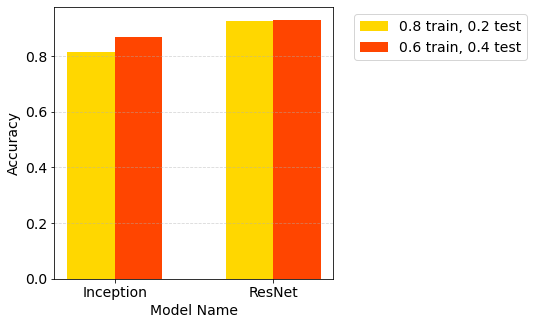

In [216]:
# Numbers of pairs of bars you want
N = 2
size = 14
# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = (inc_test_originale["val_accuracy"][-1], res_test_originale["val_accuracy"][-1])
# Specify the values of orange bars (height)
orange_bar = (inc_test_04["val_accuracy"][-1], res_test_04["val_accuracy"][-1])

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
fig = plt.figure(figsize=(5,5))

# Width of a bar 
width = 0.3  

# Plotting
plt.bar(ind, blue_bar , width, label='0.8 train, 0.2 test', color = "gold")
plt.bar(ind + width, orange_bar, width, label='0.6 train, 0.4 test', color = "orangered")

plt.xlabel('Model Name', fontsize = size)
plt.ylabel('Accuracy', fontsize = size)
#plt.title('Here goes title of the plot')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('Inception', 'ResNet'), fontsize = size)
plt.yticks(fontsize = size)
# Finding the best position for legends and putting it
plt.legend(fontsize = size, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis = "y", linestyle = "--", alpha = 0.5)
plt.show()
#fig.savefig("aug_nonaug.pdf", bbox_inches = 'tight', pad_inches = 0)

[INFO] MODEL LOADING FUNCTION ...

Selected model: InceptionV3
Selected file: InceptionV3_aug_256_50ep_32bs_0.0001lr_0.15Drop_0.2test
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_InceptionV3_aug_256_50ep_32bs_0.0001lr_0.15Drop_0.2test.txt <--

[INFO] Loading PARAMETERS completed



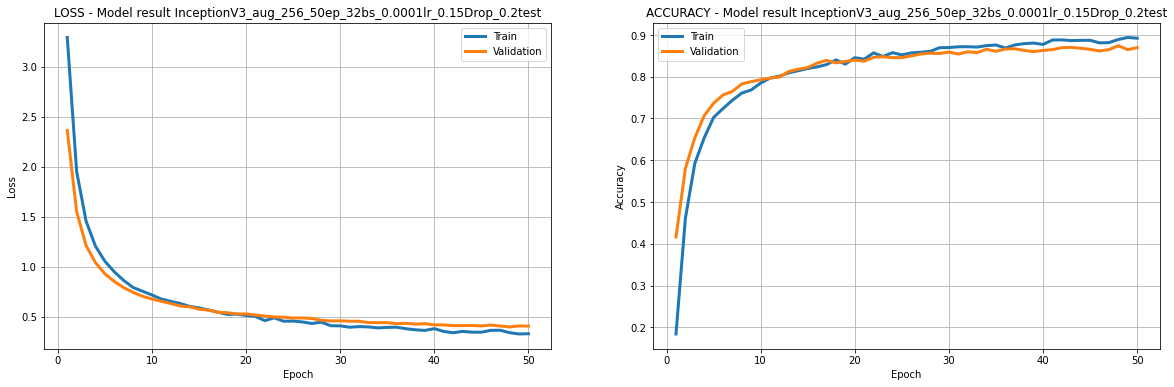

In [213]:
_, prova = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=5, mod_size_number=9, load_model=False)

In [215]:
np.max(prova["val_accuracy"])

0.8742554783821106

In [222]:
np.max(res_test_04["val_accuracy"])

0.9288315176963806

In [228]:
Print_all_models()

[INFO] ALL AVAILABLE MODEL

[1] <-- ResNet101V2
			[0] <-- ResNet101V2_128_30ep_32bs_0.001lr_0.15Drop  	[(1, 0)]
			[1] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.5Drop  	[(1, 1)]
			[2] <-- .DS_Store  	[(1, 2)]
			[3] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.5Drop  	[(1, 3)]
			[4] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.3Drop  	[(1, 4)]
			[5] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 5)]
			[6] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.3Drop  	[(1, 6)]
			[7] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop_0.4test  	[(1, 7)]
			[8] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 8)]
			[9] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.15Drop  	[(1, 9)]
			[10] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.5Drop  	[(1, 10)]
			[11] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.15Drop  	[(1, 11)]
			[12] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.5Drop  	[(1, 12)]
			[13] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.15Drop  	[(1, 13)]
[2] <-- InceptionResN

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_aug_256_30ep_64bs_0.001lr_0.5Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_aug_256_30ep_64bs_0.001lr_0.5Drop.txt <--

[INFO] Loading PARAMETERS completed



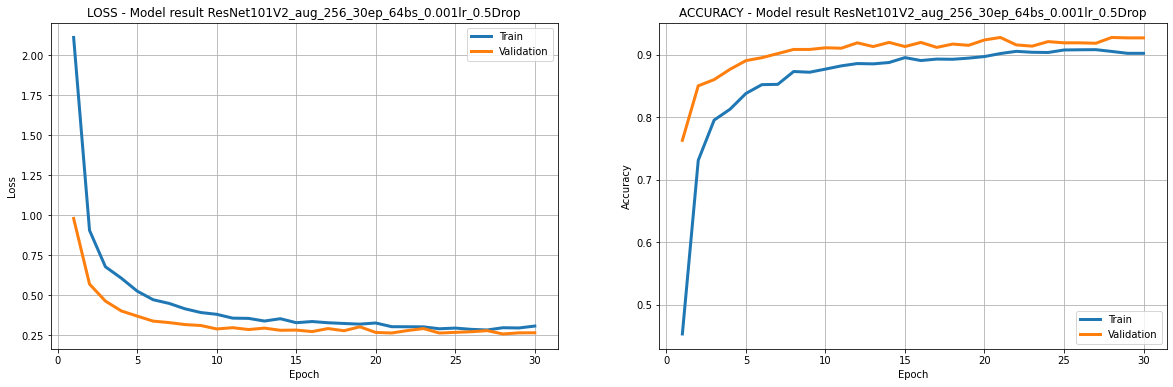

In [229]:
_, prova = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=3, load_model=False)

In [230]:
prova["val_accuracy"]

array([0.76307082, 0.85043019, 0.8603574 , 0.8769027 , 0.89080077,
       0.89543349, 0.90205163, 0.90866977, 0.90866977, 0.91131699,
       0.9106552 , 0.91925877, 0.91330242, 0.91992056, 0.91330242,
       0.91992056, 0.91197884, 0.91727334, 0.91528791, 0.92389148,
       0.92786235, 0.9159497 , 0.91396427, 0.9212442 , 0.91925877,
       0.91925877, 0.91859698, 0.92786235, 0.92720056, 0.92720056])

In [231]:
Print_all_models()

[INFO] ALL AVAILABLE MODEL

[1] <-- ResNet101V2
			[0] <-- ResNet101V2_128_30ep_32bs_0.001lr_0.15Drop  	[(1, 0)]
			[1] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.5Drop  	[(1, 1)]
			[2] <-- .DS_Store  	[(1, 2)]
			[3] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.5Drop  	[(1, 3)]
			[4] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.3Drop  	[(1, 4)]
			[5] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 5)]
			[6] <-- ResNet101V2_256_30ep_32bs_0.001lr_0.3Drop  	[(1, 6)]
			[7] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop_0.4test  	[(1, 7)]
			[8] <-- ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop  	[(1, 8)]
			[9] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.15Drop  	[(1, 9)]
			[10] <-- ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.5Drop  	[(1, 10)]
			[11] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.15Drop  	[(1, 11)]
			[12] <-- ResNet101V2_aug_256_30ep_32bs_0.0001lr_0.5Drop  	[(1, 12)]
			[13] <-- ResNet101V2_aug_256_30ep_64bs_0.001lr_0.15Drop  	[(1, 13)]
[2] <-- InceptionResN

[INFO] MODEL LOADING FUNCTION ...

Selected model: ResNet101V2
Selected file: ResNet101V2_aug_256_30ep_32bs_0.001lr_0.3Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_ResNet101V2_aug_256_30ep_32bs_0.001lr_0.3Drop.txt <--

[INFO] Loading PARAMETERS completed

[INFO] MODEL LOADING FUNCTION ...

Selected model: InceptionV3
Selected file: InceptionV3_aug_256_50ep_32bs_0.0001lr_0.25Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_InceptionV3_aug_256_50ep_32bs_0.0001lr_0.25Drop.txt <--

[INFO] Loading PARAMETERS completed

[INFO] MODEL LOADING FUNCTION ...

Selected model: VGG16
Selected file: VGG16_aug_256_30ep_32bs_0.001lr_0.15Drop
Model load SKIPPED...continue with only parameters
[INFO] Loading the associated parameters file(for plot):

	 --> parameter_VGG16_aug_256_30ep_32bs_0.001lr_0.15Drop.txt <--

[INFO] Loading PARAMETERS 

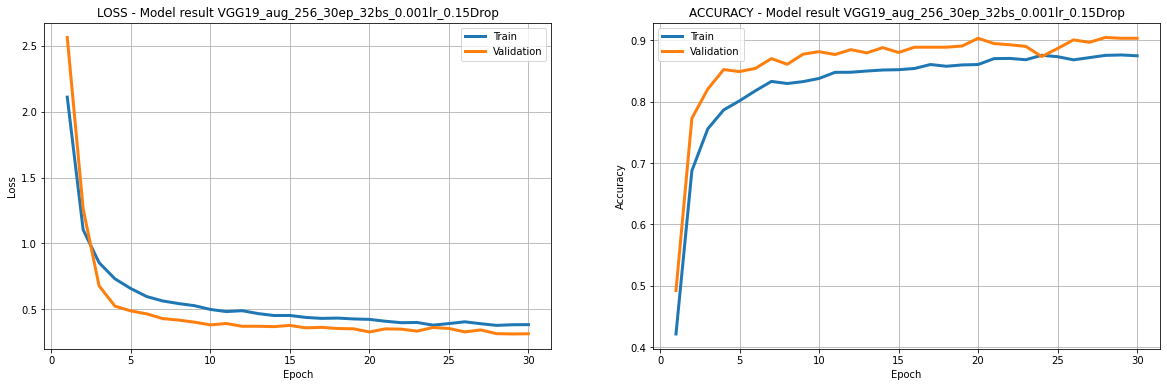

In [252]:
_, resnet = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=1, mod_size_number=4, load_model = False, print_plot=False)
_, inception = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=5, mod_size_number=13, load_model=False, print_plot=False)
_, VGG16 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=4, mod_size_number=6, load_model=False, print_plot=False)
_, VGG19 = LOAD_MODEL_and_PARAMS(if_input=False, mod_number=6, mod_size_number=1, load_model=False)

In [253]:
val_resnet = np.max(resnet["val_accuracy"])
val_inception = np.max(inception["val_accuracy"])
val_VGG16 = np.max(VGG16["val_accuracy"])
val_VGG19 = np.max(VGG19["val_accuracy"])

In [276]:
print(val_resnet)
print(val_inception)
print(val_VGG16)
print(val_VGG19)

0.9324950575828552
0.8782263398170471
0.9086697697639465
0.9046988487243652


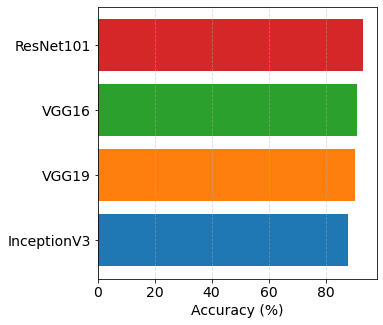

In [272]:
width = 0.8
my_list = [val_resnet, val_inception, val_VGG16, val_VGG19]
fig = plt.figure(figsize = (5,5))
plt.barh("InceptionV3", val_inception*100, width)
plt.barh("VGG19", val_VGG19*100, width)
plt.barh("VGG16", val_VGG16*100, width)
plt.barh("ResNet101", val_resnet*100, width)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.xlabel("Accuracy (%)", size = 14)


plt.grid(axis = "x", linestyle = "--", alpha = 0.5)
fig.savefig("chart.pdf", bbox_inches = 'tight', pad_inches = 0)

In [273]:
loss_resnet = np.min(resnet["val_loss"])
loss_inception = np.min(inception["val_loss"])
loss_VGG16 = np.min(VGG16["val_loss"])
loss_VGG19 = np.min(VGG19["val_loss"])

In [275]:
print(loss_resnet)
print(loss_inception)
print(loss_VGG16)
print(loss_VGG19)

0.2694151699542999
0.3931822180747986
0.293485552072525
0.3114103376865387


[INFO] MODEL LOADING FUNCTION ...

The available Model are:
			 [ 0 ] -->  .DS_Store
			 [ 1 ] -->  ResNet101V2
			 [ 2 ] -->  InceptionResNetV2
			 [ 3 ] -->  EfficientNetB0
			 [ 4 ] -->  VGG16
			 [ 5 ] -->  InceptionV3
			 [ 6 ] -->  VGG19

Select your model with a number: 
1

Select one of the following models already trained:
			 [ 0 ] -->  ResNet101V2_128_30ep_32bs_0.001lr_0.15Drop
			 [ 1 ] -->  ResNet101V2_aug_256_30ep_32bs_0.001lr_0.5Drop
			 [ 2 ] -->  .DS_Store
			 [ 3 ] -->  ResNet101V2_aug_256_30ep_64bs_0.001lr_0.5Drop
			 [ 4 ] -->  ResNet101V2_aug_256_30ep_32bs_0.001lr_0.3Drop
			 [ 5 ] -->  ResNet101V2_256_30ep_32bs_0.001lr_0.15Drop
			 [ 6 ] -->  ResNet101V2_256_30ep_32bs_0.001lr_0.3Drop
			 [ 7 ] -->  ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop_0.4test
			 [ 8 ] -->  ResNet101V2_aug_256_30ep_32bs_0.001lr_0.15Drop
			 [ 9 ] -->  ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.15Drop
			 [ 10 ] -->  ResNet101V2_aug_256_30ep_64bs_0.0001lr_0.5Drop
			 [ 11 ] -->  ResNet101V2

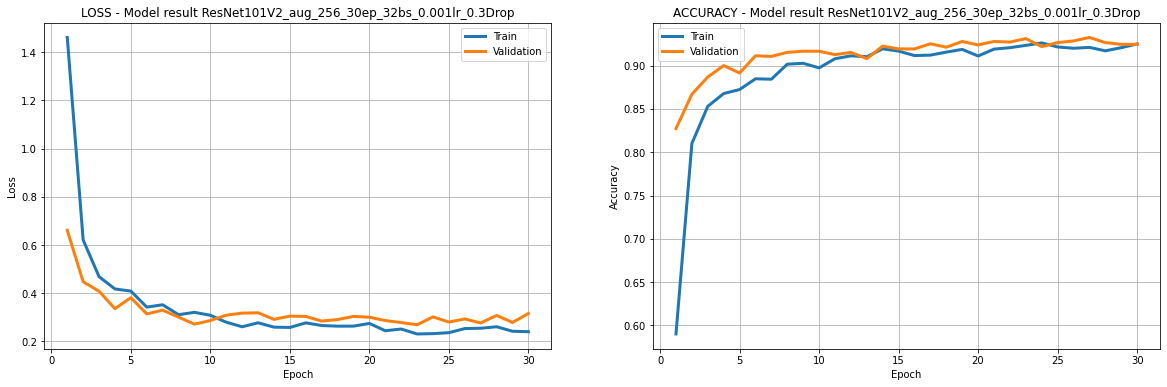

In [278]:
ResNet, par_Resnet = LOAD_MODEL_and_PARAMS()

In [ ]:
pred1 = ResNet.predict(x_test)

In [290]:
pred = (pred == pred.max(axis=1)[:,None]).astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [291]:
from sklearn.metrics import confusion_matrix
y_true = label_binarizer.inverse_transform(y_test)
y_pred = label_binarizer.inverse_transform(pred)

In [294]:
confusion = confusion_matrix(y_true, y_pred)

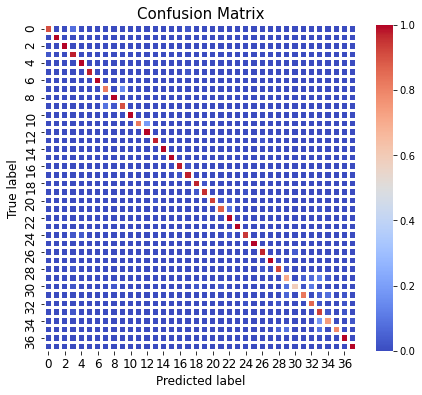

In [303]:
import seaborn
plt.figure(figsize = (7,6))

counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
normalized = confusion/confusion.sum(axis = 1)
percentages = ['{0:.2%}'.format(value) for value in normalized.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(counts, percentages)]
labels = np.asarray(labels).reshape(38,38)

seaborn.heatmap(normalized, cmap='coolwarm', fmt = "", linewidths=2, 
                linecolor='white', annot_kws={"fontsize":12})
plt.ylabel("True label", fontsize = 12)
plt.xlabel("Predicted label", fontsize = 12)
plt.title("Confusion Matrix", fontsize = 15)
plt.tick_params(axis="x",labelsize=12)
plt.tick_params(axis="y",labelsize=12)
plt.show()

In [308]:
misclassified = np.where( (y_pred == y_true)==False)

In [422]:
len(misclassified[0])

97

In [423]:
(len(y_test)-97)/len(y_test)

0.9358041032428855

In [310]:
y_pred[19]

'Tomato___Tomato_mosaic_virus'

In [311]:
y_true[19]

'Tomato___Spider_mites Two-spotted_spider_mite'

In [403]:
y_pred_1 = [y.replace("_", " ") for y in y_pred]
y_true_1 = [y.replace("_", " ") for y in y_true]
def plot_image(rgb, i):
    img = np.float32(rgb)
    fig = plt.figure(figsize = (5,5))
    plt.imshow(img)
    if y_true[i] == y_pred[i]: b= "True"
    else: b = "False"
    plt.title("True label = "+r"$\bf{" + str(y_true_1[i]) + "}$"+"\nPredicted label = "+r"$\bf{" + str(y_pred_1[i]) + "}$"+"\nCorrectly classified = "+r"$\bf{" + str(b) + "}$", size = 14)
    plt.yticks([])
    plt.xticks([])
    plt.show()
    return fig

In [424]:
y_pred

array(['Strawberry___healthy', 'Apple___Apple_scab', 'Apple___healthy',
       ..., 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus',
       'Tomato___Spider_mites Two-spotted_spider_mite'], dtype='<U50')

In [383]:
np.where(y_true== "Strawberry___Leaf_scorch")

(array([  40,   58,  139,  148,  157,  165,  202,  204,  248,  307,  395,
         629,  633,  655,  696,  749,  806,  879,  959,  961,  963, 1065,
        1075, 1111, 1208, 1210, 1216, 1279, 1309, 1342, 1377, 1423, 1432,
        1446]),)

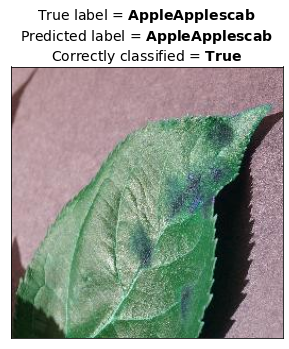

In [411]:
fig = plot_image(x_test[60], 60)
fig.savefig("foglia_corretta_1.pdf", bbox_inches = 'tight', pad_inches = 0)

In [391]:
misclassified

(array([  19,   65,   78,   86,  124,  128,  198,  216,  223,  229,  232,
         249,  255,  269,  297,  306,  321,  339,  355,  377,  393,  408,
         420,  425,  438,  444,  474,  476,  480,  481,  483,  496,  507,
         520,  528,  539,  560,  566,  659,  665,  667,  687,  709,  724,
         727,  732,  733,  809,  813,  876,  896,  898,  912,  928,  947,
         950,  957,  964,  995, 1008, 1041, 1076, 1087, 1121, 1127, 1129,
        1150, 1155, 1170, 1174, 1194, 1208, 1219, 1228, 1237, 1242, 1256,
        1267, 1273, 1294, 1296, 1308, 1316, 1320, 1324, 1325, 1330, 1344,
        1405, 1428, 1445, 1453, 1472, 1473, 1476, 1477, 1499]),)

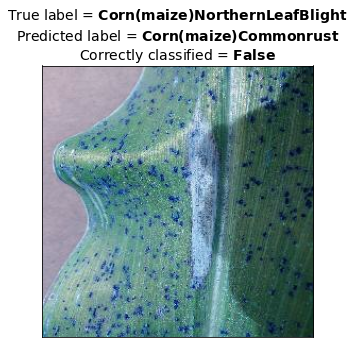

In [414]:
fig = plot_image(x_test[65], 65)
fig.savefig("foglia_sbagliata_2.pdf", bbox_inches = 'tight', pad_inches = 0)

['Strawberry   healthy',
 'Apple   Apple scab',
 'Apple   healthy',
 'Cherry (including sour)   healthy',
 'Apple   Cedar apple rust',
 'Grape   Leaf blight (Isariopsis Leaf Spot)',
 'Squash   Powdery mildew',
 'Tomato   healthy',
 'Squash   Powdery mildew',
 'Tomato   Early blight',
 'Raspberry   healthy',
 'Apple   healthy',
 'Potato   Early blight',
 'Pepper, bell   Bacterial spot',
 'Soybean   healthy',
 'Grape   Leaf blight (Isariopsis Leaf Spot)',
 'Tomato   Tomato mosaic virus',
 'Pepper, bell   healthy',
 'Tomato   Tomato Yellow Leaf Curl Virus',
 'Tomato   Spider mites Two-spotted spider mite',
 'Corn (maize)   Northern Leaf Blight',
 'Tomato   Spider mites Two-spotted spider mite',
 'Orange   Haunglongbing (Citrus greening)',
 'Strawberry   healthy',
 'Tomato   Leaf Mold',
 'Raspberry   healthy',
 'Tomato   Target Spot',
 'Apple   Black rot',
 'Strawberry   healthy',
 'Strawberry   healthy',
 'Corn (maize)   Northern Leaf Blight',
 'Tomato   healthy',
 'Squash   Powdery milde

In [356]:
str(y_true[22])

'Orange___Haunglongbing_(Citrus_greening)'

In [358]:
y_true

array(['Strawberry___healthy', 'Apple___Apple_scab', 'Apple___healthy',
       ..., 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus',
       'Tomato___Spider_mites Two-spotted_spider_mite'], dtype='<U50')

In [363]:
final = [a.replace("_", " ") for a in y_true]

In [364]:
final

['Strawberry   healthy',
 'Apple   Apple scab',
 'Apple   healthy',
 'Cherry (including sour)   healthy',
 'Apple   Cedar apple rust',
 'Grape   Leaf blight (Isariopsis Leaf Spot)',
 'Squash   Powdery mildew',
 'Tomato   healthy',
 'Squash   Powdery mildew',
 'Tomato   Early blight',
 'Raspberry   healthy',
 'Apple   healthy',
 'Potato   Early blight',
 'Pepper, bell   Bacterial spot',
 'Soybean   healthy',
 'Grape   Leaf blight (Isariopsis Leaf Spot)',
 'Tomato   Tomato mosaic virus',
 'Pepper, bell   healthy',
 'Tomato   Tomato Yellow Leaf Curl Virus',
 'Tomato   Spider mites Two-spotted spider mite',
 'Corn (maize)   Northern Leaf Blight',
 'Tomato   Spider mites Two-spotted spider mite',
 'Orange   Haunglongbing (Citrus greening)',
 'Strawberry   healthy',
 'Tomato   Leaf Mold',
 'Raspberry   healthy',
 'Tomato   Target Spot',
 'Apple   Black rot',
 'Strawberry   healthy',
 'Strawberry   healthy',
 'Corn (maize)   Northern Leaf Blight',
 'Tomato   healthy',
 'Squash   Powdery milde

In [415]:
len(y_test)

1511